In [271]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

import pandas as pd
import sys
import math
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
import re
from pythainlp.tokenize import word_tokenize
from pythainlp.corpus import thai_stopwords
from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error , r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SimpleRNN , Input

from sklearn.model_selection import GridSearchCV

### **Import Excel Files ( summary_sentiment.xlsx ).** 
 - ไฟล์ summary_sentiment.xlsx มี 235 แถว ประกอบด้วยคอลัมน์ complain_detail, positive, neutral, และ negative พร้อมทั้ง category (Positive, Neutral, Negative)

In [379]:
df = pd.read_excel('summary_sentiment.xlsx')
df.fillna(0, inplace=True)

df

,complain_id,complain_detail,positive,neutral,negative,category
0,874,การปรับแรงดันจุดซื้อขาย ระหว่าง PEA – EGAT ให้...,0.0,0.4,0.6,Negative
1,875,ปัญหาแรงดันจุดซื้อขายระหว่าง PEA – EGAT มีค่าค...,0.0,0.1,0.9,Negative
2,876,ปัญหาการตกหล่นของเอกสารขอดับไฟระหว่าง PEA – EGAT,0.0,0.1,0.9,Negative
3,877,ขอให้ กฟผ.พิจารณาเพิ่มขนาดหม้อแปลง KT2A ทีส่ฟ....,0.0,0.4,0.6,Negative
4,881,"On site spare parts checking, Present WI how t...",0.0,1.0,0.0,Neutral
...,...,...,...,...,...,...
230,2191,โรงไฟฟ้า แจ้งต่อคณะว่า มีความประสงค์ที่จะเข้าเ...,1.0,0.0,0.0,Positive
231,2192,เมื่อวันที่ 16 พ.ย. 2567 DCAP มีแผนบำรุงรักษา ...,0.0,0.4,0.6,Negative
232,2193,บริษัท หงสาพาวเวอร์ จำกัด\nข้อเสนอแนะ (คำชม)\n...,0.6,0.4,0.0,Positive
233,2195,เนื่องด้วย ในวันที่ 16 พฤศจิกายน 2567 เวลา 6....,0.0,0.4,0.6,Negative


In [381]:
df = df.sort_values(by='complain_id')
df_label = df.iloc[0:]
df_label

,complain_id,complain_detail,positive,neutral,negative,category
0,874,การปรับแรงดันจุดซื้อขาย ระหว่าง PEA – EGAT ให้...,0.0,0.4,0.6,Negative
1,875,ปัญหาแรงดันจุดซื้อขายระหว่าง PEA – EGAT มีค่าค...,0.0,0.1,0.9,Negative
2,876,ปัญหาการตกหล่นของเอกสารขอดับไฟระหว่าง PEA – EGAT,0.0,0.1,0.9,Negative
3,877,ขอให้ กฟผ.พิจารณาเพิ่มขนาดหม้อแปลง KT2A ทีส่ฟ....,0.0,0.4,0.6,Negative
4,881,"On site spare parts checking, Present WI how t...",0.0,1.0,0.0,Neutral
...,...,...,...,...,...,...
230,2191,โรงไฟฟ้า แจ้งต่อคณะว่า มีความประสงค์ที่จะเข้าเ...,1.0,0.0,0.0,Positive
231,2192,เมื่อวันที่ 16 พ.ย. 2567 DCAP มีแผนบำรุงรักษา ...,0.0,0.4,0.6,Negative
232,2193,บริษัท หงสาพาวเวอร์ จำกัด\nข้อเสนอแนะ (คำชม)\n...,0.6,0.4,0.0,Positive
233,2195,เนื่องด้วย ในวันที่ 16 พฤศจิกายน 2567 เวลา 6....,0.0,0.4,0.6,Negative


### **Import Excel Files ( complain_unlabelled.xlsx ).** 
 - ไฟล์ complain_unlabelled.xlsx มี 300 แถว ประกอบด้วยคอลัมน์ complain_detail และจะต้องทำการ Labeling โดยการใช้ข้อมูลที่มี Label เป็นตัวตั้งตน

In [384]:
df_nonlabel = pd.read_excel('complain_unlabelled.xlsx')
df_nonlabel

,complain_detail
0,สฟ.ภูเก็ต 2 ขอรายละเอียดการทำงานของ Breaker PK...
1,"Poor Work Quality For MO RPC-C1,C2 1.Minor Acc..."
2,โรงงานประสบปัญหาไฟตกบ่อยและเครื่องจักร Trip จา...
3,ขอปรับปรุง Distance Relay Line PEA ให้สามารถทร...
4,แนวโน้มปัญหา Fault Level กฟภ. สอบถามว่า เนื่...
...,...
295,การติดต่อสื่อสารกันทางวิทยุ การติดต่อสื่อสารกั...
296,การรายงานอุปกรณ์ป้องกันทำงาน การรายงานอุปกรณ์ป...
297,อยากให้ กฟผ. ปรับแผนงานดับจ่ายกระแสไฟฟ้า แผนงา...
298,อยากให้เพิ่มบุคลากรเฉพาะทางให้มีหลายทีม อยากให...


### **Preprocessing Text** 
 - การเตรียมข้อมูลก่อนนำเข้าโมเดลด้วยการ ลบเครื่องหมายและตัวเลข , ลบคำภาษาอังกฤษ (เนื่องจากทำโมเดลภาษาไทย) , จัดการช่องว่าง , แบ่งคำและลบคำที่ไม่มีความหมาย เช่น และ หรือ .... 

In [387]:
def preprocess_text(text):
    """Preprocesses Thai text."""

    # Remove symbols and numbers
    text = re.sub(r'[^ก-๙a-zA-Z\s]', '', text)
    # Remove English words
    text = re.sub(r'[a-zA-Z]', '', text)

    # Normalize whitespace
    text = ' '.join(text.split())

    # Tokenization and stopword removal
    stopwords = set(thai_stopwords())
    tokens = word_tokenize(text, engine="newmm")  # Using "newmm" engine for better Thai tokenization

    filtered_tokens = [word for word in tokens if word not in stopwords]

    return " ".join(filtered_tokens)

### **Data Labeling**
**วิธีการ Labeling**
- ใช้ similarity-base โดยคำนวณจากความคล้ายคลึง ( cosine similarity ) ระหว่างข้อความที่มี Label และไม่มี Label โดยการใช้คะแนนจากข้อความที่มี Label เทียบกับข้อความที่ไม่มี Label โดยใช้การ weighted sentiment
  
**ได้ค่าอะไรจากการ Labeling?**
- คะแนน sentiment ( weighted_positive, weighted_neutral, weighted_negative ) สำหรับข้อมูลที่ไม่มี Label จำนวน 300 แถว โดยคำนวณจากความคล้ายคลึงกับข้อมูลที่มี Label ตัวอย่าง. Positive: 0.0 , Neutral: 0.1978 , Negative: 0.8022

**ทำไมถึงได้เลือกวิธีการ Labeling นี้?**
- ข้อมูลที่มี Label มีจำนวนน้อยด้วยข้อมูลที่มี Label เพียง 235 แถวซึ่งนั้นไม่เพียงพอที่จะฝึกฝนโมเดล Machine Learning ได้ดีพอ  การใช้ similarity-base labeling จึงเป็นวิธีที่เหมาะสมในการเปรียบเทียบและอ้างอิงคะแนนจากข้อมูลที่มี Label ไปยังข้อมูลที่ไม่มี Label , การใช้ cosine similarity ช่วยให้สามารถหาความสัมพันธ์ระหว่างข้อความได้ โดยตั้งสมมติฐานว่าข้อความที่คล้ายกันน่าจะมี sentiment คล้ายกัน

### **Word Embedding**

**ใช้ 3 วิธีการ Embedding เพื่อเปรียบเทียบประสิทธิภาพ คือ Word2Vec , TF-IDF , WangchanBERTa**
- Word2Vec: สร้าง Vector Representation จากข้อความโดยฝึกโมเดล Word2Vec บนข้อมูลทั้งหมด (ทั้งที่มีและไม่มี Label)
- TF-IDF (Term Frequency-Inverse Document Frequency): ใช้ TfidfVectorizer เพื่อแปลงข้อความเป็น Vector โดยพิจารณาความสำคัญของคำในเอกสาร
- WangchanBERTa: ใช้โมเดลภาษาไทย (airesearch/wangchanberta-base-att-spm-uncased) ซึ่งเป็น Transformer-Based Model เพื่อสร้าง Embedding ที่เข้าใจบริบทของภาษาไทย

**ได้ค่าอะไร ?**
- Word2Vec Similarity Matrix ขนาด 235x300 ( เปรียบเทียบ 235 ข้อความที่มี Label กับ 300 ข้อความที่ไม่มี Label ) ค่าเฉลี่ยสูง (>0.99) แสดงถึงความคล้ายคลึงสูง
- TF-IDF Similarity Matrix ขนาด 235x300 ค่าเฉลี่ยต่ำกว่า Word2Vec (เช่น 0.0-0.17) เพราะเน้นคำสำคัญมากกว่าบริบท
- WangchanBERTa Similarity Matrix: ขนาด 235x300 ค่าแสดงความคล้ายคลึงที่แม่นยำในบริบทภาษาไทย

**ทำไมถึงได้เลือกวิธีการ Embedding นี้?**
- Word2Vec: เหมาะกับการจับความสัมพันธ์เชิงความหมายของคำในระดับพื้นฐาน และใช้ทรัพยากรน้อย เหมาะกับข้อมูลขนาดเล็กถึงกลาง
- TF-IDF: วิธีคลาสสิกที่เน้นคำสำคัญในข้อความ ช่วยให้เห็นความแตกต่างของคำที่ปรากฏบ่อยหรือหายาก เหมาะสำหรับเปรียบเทียบประสิทธิภาพ
- WangchanBERTa: เป็นโมเดลที่เข้าใจบริบทภาษาไทยได้ดีที่สุด เหมาะกับข้อความภาษาไทยที่มีความซับซ้อน และคาดว่าจะให้ผลลัพธ์แม่นยำที่สุด

**ลักษณะค่า vector** 
- เป็นทศนิยมบวกหรือลบ เช่น 0.12 , -0.45 , 0.78 , ... , -0.23 ซึ่งจะสะท้อนความสัมพันธ์เชิงความหมายของคำ

### **Define Word2Vec Cosine Similarity Function**

- สร้าง word embedding และคำนวณค่า cosine similarity ด้วย Word2Vec

In [392]:
def word2vec_cosine_similarity(df1, df2, text_column='review_message'): #Word2Vec
    """
    Calculates cosine similarity between review messages in two DataFrames using Word2Vec.

    Args:
        df1 (pd.DataFrame): The first DataFrame.
        df2 (pd.DataFrame): The second DataFrame.
        text_column (str): The name of the column containing review messages.

    Returns:
        pd.DataFrame: A DataFrame containing cosine similarity scores.
    """
    if text_column not in df1.columns or text_column not in df2.columns:
        raise ValueError(f"Column '{text_column}' not found in one or both DataFrames.")

    # Apply preprocessing (assuming preprocess_text returns a list of words)
    df1[text_column] = df1[text_column].apply(preprocess_text)
    df2[text_column] = df2[text_column].apply(preprocess_text)

    # Combine all texts to train Word2Vec
    all_sentences = df1[text_column].tolist() + df2[text_column].tolist()

    # Train the Word2Vec model
    model = Word2Vec(sentences=all_sentences, vector_size=100, window=5, min_count=1, workers=4)

    # Function to create average embeddings for a sentence
    def get_sentence_embedding(sentence, model):
        word_vectors = [model.wv[word] for word in sentence if word in model.wv]
        return np.mean(word_vectors, axis=0) if word_vectors else np.zeros(model.vector_size)

    # Create embeddings for df1 and df2
    embeddings_df1 = np.array([get_sentence_embedding(sent, model) for sent in df1[text_column]])
    embeddings_df2 = np.array([get_sentence_embedding(sent, model) for sent in df2[text_column]])

    # Calculate cosine similarity
    similarity_matrix = cosine_similarity(embeddings_df1, embeddings_df2)

    # Create a DataFrame for the results
    results_df = pd.DataFrame(similarity_matrix, index=df1.index, columns=df2.index)

    return results_df

In [394]:
print("\nRunning Word2Vec Cosine Similarity...") # 235 rows from Summary.xlsx
word2vec_similarity = word2vec_cosine_similarity(df_label.copy(), df_nonlabel.copy(), text_column='complain_detail')
print("Word2Vec Similarity Matrix :")
print(word2vec_similarity)


Running Word2Vec Cosine Similarity...
Word2Vec Similarity Matrix :
          0    1         2         3         4         5         6    \
0    0.993521  0.0  0.993277  0.996599  0.998073  0.998625  0.996968   
1    0.974360  0.0  0.977869  0.967440  0.966261  0.962313  0.951164   
2    0.993449  0.0  0.993066  0.994493  0.996680  0.997113  0.994062   
3    0.999233  0.0  0.999225  0.999601  0.999527  0.999094  0.996896   
4    0.000000  0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
..        ...  ...       ...       ...       ...       ...       ...   
230  0.999722  0.0  0.999666  0.999198  0.997939  0.997232  0.995601   
231  0.999368  0.0  0.999344  0.997717  0.997199  0.996423  0.993296   
232  0.998017  0.0  0.997907  0.996339  0.996603  0.996034  0.992262   
233  0.999350  0.0  0.999384  0.997405  0.996528  0.995608  0.992547   
234  0.996914  0.0  0.995643  0.998303  0.998371  0.998949  0.999295   

          7         8         9    ...       290       291       29

- จากค่า cosine similarity ได้ค่าสูงมาก > 0.99 แสดงว่า vector มีความคล้ายคลึงกันสูง

### **Define TF-IDF Cosine Similarity Function**

- สร้าง word embedding และคำนวณค่า cosine similarity ด้วย TF-IDF

In [398]:
def tfidf_cosine_similarity(df1, df2, text_column='review_message'): #TF-IDF
    """
    Calculates cosine similarity between review messages in two DataFrames using TF-IDF.

    Args:
        df1 (pd.DataFrame): The first DataFrame.
        df2 (pd.DataFrame): The second DataFrame.
        text_column (str): The name of the column containing review messages.

    Returns:
        pd.DataFrame: A DataFrame containing cosine similarity scores.
    """
    if text_column not in df1.columns or text_column not in df2.columns:
        raise ValueError(f"Column '{text_column}' not found in one or both DataFrames.")

    # Apply preprocessing
    df1[text_column] = df1[text_column].apply(preprocess_text)
    df2[text_column] = df2[text_column].apply(preprocess_text)

    # Combine all texts from df1 and df2 to fit the TF-IDF vectorizer
    all_texts = df1[text_column].tolist() + df2[text_column].tolist()

    # Create TF-IDF Vectorizer
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(all_texts)

    # Split embeddings for df1 and df2
    tfidf_df1 = tfidf_matrix[:len(df1)]
    tfidf_df2 = tfidf_matrix[len(df1):]

    # Calculate cosine similarity
    similarity_matrix = cosine_similarity(tfidf_df1, tfidf_df2)

    # Create a DataFrame for the results
    results_df = pd.DataFrame(similarity_matrix, index=df1.index, columns=df2.index)

    return results_df

In [400]:
print("Running TF-IDF Cosine Similarity...") # 235 rows from Summary.xlsx
tfidf_similarity = tfidf_cosine_similarity(df_label.copy(), df_nonlabel.copy(), text_column='complain_detail')
print("TF-IDF Similarity Matrix :")
print(tfidf_similarity)

Running TF-IDF Cosine Similarity...
TF-IDF Similarity Matrix :
          0    1         2         3         4         5         6    \
0    0.000000  0.0  0.035722  0.000000  0.045093  0.051791  0.000000   
1    0.000000  0.0  0.044050  0.000000  0.092882  0.106680  0.036757   
2    0.000000  0.0  0.042767  0.000000  0.090177  0.103573  0.035686   
3    0.036060  0.0  0.004664  0.087224  0.173573  0.116631  0.145198   
4    0.000000  0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
..        ...  ...       ...       ...       ...       ...       ...   
230  0.020598  0.0  0.004482  0.000000  0.035787  0.041103  0.000000   
231  0.119025  0.0  0.055462  0.082936  0.019115  0.021955  0.088841   
232  0.000000  0.0  0.000000  0.000000  0.000000  0.000000  0.031375   
233  0.102913  0.0  0.042217  0.053454  0.000000  0.000000  0.082409   
234  0.163349  0.0  0.006143  0.053423  0.020447  0.023485  0.032023   

          7         8         9    ...       290       291       292  \


- จากค่า cosine similarity ได้ค่าต่ำ 0.0 - 0.17 แสดงว่า vector แยกความแตกต่างได้ดีกว่า Word2Vec

### **Define WangchanBERTa Cosine Similarity Function**

- สร้าง word embedding และคำนวณค่า cosine similarity ด้วย WangchanBERTa

In [404]:
def wangchan_cosine_similarity(df1, df2, text_column='review_message', 
                                     model_name='airesearch/wangchanberta-base-att-spm-uncased'):
    """
    Calculates cosine similarity between review messages in two DataFrames using WangchanBERTa.

    Args:
        df1 (pd.DataFrame): The first DataFrame.
        df2 (pd.DataFrame): The second DataFrame.
        text_column (str): The name of the column containing review messages.
        model_name (str): The name of the WangchanBERTa model to use. 
                          Defaults to 'airesearch/wangchanberta-base-att-spm-uncased'.

    Returns:
        pd.DataFrame: A DataFrame containing cosine similarity scores.
    """

    if text_column not in df1.columns or text_column not in df2.columns:
        raise ValueError(f"Column '{text_column}' not found in one or both DataFrames.")
        
    # Apply preprocessing
    df1[text_column] = df1[text_column].apply(preprocess_text)
    df2[text_column] = df2[text_column].apply(preprocess_text)
    # Load WangchanBERTa tokenizer and model
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name)

    # Function to get embeddings
    def get_embeddings(texts):
        """
        Tokenizes texts and generates embeddings using the specified model.
        """
        # Tokenize the texts
        encoded_input = tokenizer(texts, padding=True, truncation=True, return_tensors='pt')

        # Get embeddings
        with torch.no_grad():
            model_output = model(**encoded_input)
        
        # Extract embeddings (e.g., from the last hidden state)
        embeddings = model_output.last_hidden_state.mean(dim=1)  # Or another pooling strategy

        return embeddings

    # Get embeddings for df1 and df2
    embeddings_df1 = get_embeddings(df1[text_column].tolist())
    embeddings_df2 = get_embeddings(df2[text_column].tolist())

    # Calculate cosine similarity
    similarity_matrix = cosine_similarity(embeddings_df1, embeddings_df2)

    # Create a DataFrame to store the results
    results_df = pd.DataFrame(similarity_matrix, index=df1.index, columns=df2.index)

    return results_df

In [406]:
print("\nRunning WangchanBERTa Cosine Similarity...") # 235 rows from Summary.xlsx
wangchan_similarity = wangchan_cosine_similarity(df_label.copy(), df_nonlabel.copy(), text_column="complain_detail")
print("WangchanBERTa Similarity Matrix :")
print(wangchan_similarity)


Running WangchanBERTa Cosine Similarity...


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


WangchanBERTa Similarity Matrix :
          0         1         2         3         4         5         6    \
0    0.346457  0.548491  0.388823  0.364530  0.373020  0.373872  0.344736   
1    0.607443  0.471557  0.651009  0.590572  0.653861  0.654143  0.633035   
2    0.214075  0.316935  0.235107  0.250875  0.227868  0.232514  0.207572   
3    0.794566  0.408549  0.766887  0.841113  0.815041  0.821833  0.856063   
4    0.381997  0.999998  0.375437  0.379211  0.462546  0.463720  0.370587   
..        ...       ...       ...       ...       ...       ...       ...   
230  0.806084  0.443530  0.736387  0.856610  0.784859  0.793307  0.813828   
231  0.656307  0.216838  0.643708  0.660130  0.562840  0.558117  0.628102   
232  0.650232  0.468114  0.667489  0.662846  0.661291  0.671644  0.711406   
233  0.786882  0.298706  0.772649  0.770619  0.686260  0.684695  0.760935   
234  0.768528  0.257792  0.715435  0.762814  0.646105  0.645881  0.737108   

          7         8         9    ...   

- จากค่า cosine similarity มีค่า vector อยู่ในช่วง 0 - 1 บ่งบอกได้ว่าค่านี้สะท้อนถึงระดับความคล้ายคลึงกันระหว่างข้อความสองข้อความในแง่ของบริบทและความหมายเชิงลึก

### **Find most similar text**

- เลือกค่า cosine similarity ที่มากที่สุด 3 อันดับแรกใน df1 และ สำหรับแต่ละข้อความในตาราง df2 แล้วบอกว่าข้อความเหล่านั้นคล้ายกันแค่ไหน โดยใช้ค่า cosine similarity และบอก complain_id ของข้อความแต่ละอันดับด้วย

In [409]:
def find_most_similar_text(df1, df2, similarity_df, text_column='review_message', 
                            positive_col='positive', neutral_col='neutral', negative_col='negative', 
                            complain_id_col='complain_id', k=3):
    """
    Finds the top k most similar texts in df1 for each text in df2 and their cosine similarity,
    including complain_id for each of the top k matches.

    Args:
        df1 (pd.DataFrame): The first DataFrame, containing the sentiment scores and complain_id.
        df2 (pd.DataFrame): The second DataFrame.
        similarity_df (pd.DataFrame): DataFrame with cosine similarity scores.
        text_column (str): The name of the column containing review messages.
        positive_col (str): column name containing Positive Score in df1.
        neutral_col (str): column name containing Neutral Score in df1.
        negative_col (str): column name containing Negative Score in df1.
        complain_id_col (str): column name containing complain_id in df1.
        k (int): Number of most similar texts to find.

    Returns:
        pd.DataFrame: A DataFrame with DF2_Text, Most_Similar_DF1_1, CosineSimilarity_1, Positive_1, 
                      Neutral_1, Negative_1, Complain_id_1, ..., columns.
    """
    results = []
    for j, row in df2.iterrows():  # Iterate through df2
        similar_indices = np.argsort(similarity_df.iloc[:, j])[-k:][::-1]  # Find top k similar indices
        result = {'DF2_Text': row[text_column]}
        for i, similar_index in enumerate(similar_indices):
            similar_df1_row = df1.iloc[similar_index]
            result[f'Complain_id_{i+1}'] = similar_df1_row[complain_id_col]  # Add complain_id
            result[f'Most_Similar_DF1_{i+1}'] = similar_df1_row[text_column]
            result[f'CosineSimilarity_{i+1}'] = similarity_df.iloc[similar_index, j]
            result[f'Positive_{i+1}'] = similar_df1_row[positive_col]
            result[f'Neutral_{i+1}'] = similar_df1_row[neutral_col]
            result[f'Negative_{i+1}'] = similar_df1_row[negative_col]

        results.append(result)
    return pd.DataFrame(results)

In [410]:
def apply_sigmoid_to_scores(df, positive_col='positive', neutral_col='neutral', negative_col='negative'):
    """Applies sigmoid function to the specified score columns in the DataFrame."""
    df_copy = df.copy()
    df_copy[positive_col] = df_copy[positive_col].apply(sigmoid)
    df_copy[neutral_col] = df_copy[neutral_col].apply(sigmoid)
    df_copy[negative_col] = df_copy[negative_col].apply(sigmoid)
    
    # L1 Normalization
    df_copy['sum_abs_scores'] = df_copy[positive_col].abs() + df_copy[neutral_col].abs() + df_copy[negative_col].abs()
    df_copy[positive_col] = df_copy[positive_col].abs() / df_copy['sum_abs_scores']
    df_copy[neutral_col] = df_copy[neutral_col].abs() / df_copy['sum_abs_scores']
    df_copy[negative_col] = df_copy[negative_col].abs() / df_copy['sum_abs_scores']
    df_copy = df_copy.drop(columns=['sum_abs_scores'])

    return df_copy

def sigmoid(x):
    """Sigmoid function."""
    return 1 / (1 + math.exp(-x))

In [411]:
try: # 300 rows from complain_unlablled.xlsx by Word2Vec
  similarity_df = word2vec_cosine_similarity(df_label.copy(), df_nonlabel.copy(), text_column="complain_detail")
  result_word2vec = find_most_similar_text(df_label.copy(), df_nonlabel.copy(), similarity_df, text_column="complain_detail",k=3)
  # result_df_sigmoid = apply_sigmoid_to_scores(result_df) #Apply new support function.
  print(result_word2vec)
except ValueError as e:
  print(f"Error: {e}")

                                              DF2_Text  Complain_id_1  \
0    สฟ.ภูเก็ต 2 ขอรายละเอียดการทำงานของ Breaker PK...           2095   
1    Poor Work Quality For MO RPC-C1,C2 1.Minor Acc...           2196   
2    โรงงานประสบปัญหาไฟตกบ่อยและเครื่องจักร Trip จา...           2179   
3    ขอปรับปรุง Distance Relay Line PEA ให้สามารถทร...           2051   
4    แนวโน้มปัญหา Fault Level   กฟภ. สอบถามว่า เนื่...            884   
..                                                 ...            ...   
295  การติดต่อสื่อสารกันทางวิทยุ การติดต่อสื่อสารกั...           2025   
296  การรายงานอุปกรณ์ป้องกันทำงาน การรายงานอุปกรณ์ป...           2100   
297  อยากให้ กฟผ. ปรับแผนงานดับจ่ายกระแสไฟฟ้า แผนงา...           2094   
298  อยากให้เพิ่มบุคลากรเฉพาะทางให้มีหลายทีม อยากให...           2034   
299  ต้องการให้ปรับปรุงมุมมองของพนักงาน กฟผ. ต้องกา...           2068   

                                    Most_Similar_DF1_1  CosineSimilarity_1  \
0    ตามที่ กฟผ. ได้ให้บริการงานบริการที่ปรึก

In [412]:
result_word2vec.head()

,DF2_Text,Complain_id_1,Most_Similar_DF1_1,CosineSimilarity_1,Positive_1,Neutral_1,Negative_1,Complain_id_2,Most_Similar_DF1_2,CosineSimilarity_2,Positive_2,Neutral_2,Negative_2,Complain_id_3,Most_Similar_DF1_3,CosineSimilarity_3,Positive_3,Neutral_3,Negative_3
0,สฟ.ภูเก็ต 2 ขอรายละเอียดการทำงานของ Breaker PK...,2095,ตามที่ กฟผ. ได้ให้บริการงานบริการที่ปรึกษาวิศว...,0.999889,0.0,0.3,0.7,2113,บ.Ratch-Lao Service ต้องการให้ กฟผ. จัดงานสัมม...,0.999837,0.7,0.3,0.0,2109,คุณจรัสฯ แจ้งประเด็นสำคัญให้ กฟผ. เรื่อง บริษั...,0.999827,0.5,0.5,0.0
1,"Poor Work Quality For MO RPC-C1,C2 1.Minor Acc...",2196,จากการประชุมเยี่ยมเยียนโรงไฟฟ้า บริษัท กัลฟ์ พ...,0.000000,0.6,0.4,0.0,2009,บริษัท กัลฟ์ วีทีพี จำกัด แจ้งว่าเกิดความบกพร่...,0.000000,0.0,0.2,0.8,2033,ปัญหางานซ่อม Valve หลังงานซ่อม ไม่ดีพอ,0.000000,0.0,0.0,1.0
2,โรงงานประสบปัญหาไฟตกบ่อยและเครื่องจักร Trip จา...,2179,โครงการสำรวจความพึงพอใจลูกค้าและผู้มีส่วนได้เส...,0.999921,0.0,0.0,1.0,2133,โรงไฟฟ้าแจ้งเรื่องการเดินเครื่องประสงค์ให้ กฟผ...,0.999851,0.0,1.0,0.0,2022,บริษัท กัลฟ์ วีทีพี จำกัด แจ้งว่าเกิดความบกพร่...,0.999830,0.0,0.2,0.8
3,ขอปรับปรุง Distance Relay Line PEA ให้สามารถทร...,2051,การทำการตลาดของ กฟผ. ธุรกิจ O&M ต้องทำ Direct ...,0.999755,0.0,0.8,0.2,2139,ขอให้ทีม กฟผ. นำเอา Lesson Learn จากการทำ Majo...,0.999722,0.0,0.8,0.2,2127,คุณสุกฤษดิ์ใจดี ต าแหน่ง Business Development ...,0.999718,0.5,0.5,0.0
4,แนวโน้มปัญหา Fault Level กฟภ. สอบถามว่า เนื่...,884,หน่วยงาน กฟผ มีการให้ความรู้เพิ่มเติมกับผู้ปฏิ...,0.999574,1.0,0.0,0.0,877,ขอให้ กฟผ.พิจารณาเพิ่มขนาดหม้อแปลง KT2A ทีส่ฟ....,0.999553,0.0,0.4,0.6,2080,กฟผ. ธุรกิจ O&M จะเข้ามาให้บริการในกลุ่ม จะต้อ...,0.999506,0.0,0.5,0.5


In [413]:
try: # 300 rows from complain_unlablled.xlsx by TF-IDF
  similarity_df = tfidf_cosine_similarity(df_label.copy(), df_nonlabel.copy(), text_column="complain_detail")
  result_tfidf = find_most_similar_text(df_label.copy(), df_nonlabel.copy(), similarity_df, text_column="complain_detail",k=3)
  # result_df_sigmoid = apply_sigmoid_to_scores(result_df) #Apply new support function.
  print(result_tfidf)
except ValueError as e:
  print(f"Error: {e}")

                                              DF2_Text  Complain_id_1  \
0    สฟ.ภูเก็ต 2 ขอรายละเอียดการทำงานของ Breaker PK...           1981   
1    Poor Work Quality For MO RPC-C1,C2 1.Minor Acc...           2196   
2    โรงงานประสบปัญหาไฟตกบ่อยและเครื่องจักร Trip จา...           2038   
3    ขอปรับปรุง Distance Relay Line PEA ให้สามารถทร...           1981   
4    แนวโน้มปัญหา Fault Level   กฟภ. สอบถามว่า เนื่...           2080   
..                                                 ...            ...   
295  การติดต่อสื่อสารกันทางวิทยุ การติดต่อสื่อสารกั...           2162   
296  การรายงานอุปกรณ์ป้องกันทำงาน การรายงานอุปกรณ์ป...            906   
297  อยากให้ กฟผ. ปรับแผนงานดับจ่ายกระแสไฟฟ้า แผนงา...           1981   
298  อยากให้เพิ่มบุคลากรเฉพาะทางให้มีหลายทีม อยากให...            903   
299  ต้องการให้ปรับปรุงมุมมองของพนักงาน กฟผ. ต้องกา...           2166   

                                    Most_Similar_DF1_1  CosineSimilarity_1  \
0    - แจ้งรายละเอียดอุปกรณ์ป้องกันที่จ่ายไฟใ

In [414]:
try: # 300 rows from complain_unlablled.xlsx by WangchanBERTa
  similarity_df = wangchan_cosine_similarity(df_label.copy(), df_nonlabel.copy(), text_column="complain_detail")
  result_wangchan = find_most_similar_text(df_label.copy(), df_nonlabel.copy(), similarity_df, text_column="complain_detail",k=3)
  # result_df_sigmoid = apply_sigmoid_to_scores(result_df) #Apply new support function.
  print(result_wangchan)
except ValueError as e:
  print(f"Error: {e}")

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


                                              DF2_Text  Complain_id_1  \
0    สฟ.ภูเก็ต 2 ขอรายละเอียดการทำงานของ Breaker PK...           2155   
1    Poor Work Quality For MO RPC-C1,C2 1.Minor Acc...           2096   
2    โรงงานประสบปัญหาไฟตกบ่อยและเครื่องจักร Trip จา...           2097   
3    ขอปรับปรุง Distance Relay Line PEA ให้สามารถทร...           2133   
4    แนวโน้มปัญหา Fault Level   กฟภ. สอบถามว่า เนื่...           2082   
..                                                 ...            ...   
295  การติดต่อสื่อสารกันทางวิทยุ การติดต่อสื่อสารกั...           2179   
296  การรายงานอุปกรณ์ป้องกันทำงาน การรายงานอุปกรณ์ป...           2155   
297  อยากให้ กฟผ. ปรับแผนงานดับจ่ายกระแสไฟฟ้า แผนงา...           2172   
298  อยากให้เพิ่มบุคลากรเฉพาะทางให้มีหลายทีม อยากให...           2065   
299  ต้องการให้ปรับปรุงมุมมองของพนักงาน กฟผ. ต้องกา...           2134   

                                    Most_Similar_DF1_1  CosineSimilarity_1  \
0    การแจ้งข้อมูล Relay ขณะเกิดเหตุการณ์บางส

## Fixed
- totalsimilarity = cosine similarity 1 + cosine similairty 2 + cosine similarity 3
- weight_(positive/neutral/negative) = (label * cosine similarity 1 ) + ( label * cosine similarity 2 ) + ( label * cosine similarity 3 ) / total similarity

In [416]:
def calculate_weighted_sentiment(result_df, k=3):
    """
    Calculates weighted sentiment scores based on cosine similarity.

    Args:
        result_df (pd.DataFrame): DataFrame containing similarity results.
        k (int): Number of top similar texts (default is 3).

    Returns:
        pd.DataFrame: DataFrame with DF2_Text, Weighted_Positive, Weighted_Neutral, Weighted_Negative.
    """
    weighted_results = []
    for index, row in result_df.iterrows():
        cosine_similarities = [row[f'CosineSimilarity_{i+1}'] for i in range(k)]
        total_similarity = sum(cosine_similarities)

        if total_similarity == 0:  # Handle case where all similarities are 0
            weighted_positive = 0
            weighted_neutral = 0
            weighted_negative = 0
        else:
            weighted_positive = sum([row[f'Positive_{i+1}'] * row[f'CosineSimilarity_{i+1}'] for i in range(k)]) / total_similarity
            weighted_neutral = sum([row[f'Neutral_{i+1}'] * row[f'CosineSimilarity_{i+1}'] for i in range(k)]) / total_similarity
            weighted_negative = sum([row[f'Negative_{i+1}'] * row[f'CosineSimilarity_{i+1}'] for i in range(k)]) / total_similarity

        weighted_results.append({
            'DF2_Text': row['DF2_Text'],
            'Weighted_Positive': weighted_positive,
            'Weighted_Neutral': weighted_neutral,
            'Weighted_Negative': weighted_negative
        })

    return pd.DataFrame(weighted_results)

In [417]:
weighted_sentiment_word2vec = calculate_weighted_sentiment(result_word2vec)

weighted_sentiment_word2vec

,DF2_Text,Weighted_Positive,Weighted_Neutral,Weighted_Negative
0,สฟ.ภูเก็ต 2 ขอรายละเอียดการทำงานของ Breaker PK...,0.399993,0.366665,0.233342
1,"Poor Work Quality For MO RPC-C1,C2 1.Minor Acc...",0.000000,0.000000,0.000000
2,โรงงานประสบปัญหาไฟตกบ่อยและเครื่องจักร Trip จา...,0.000000,0.399992,0.600008
3,ขอปรับปรุง Distance Relay Line PEA ให้สามารถทร...,0.166664,0.700001,0.133334
4,แนวโน้มปัญหา Fault Level กฟภ. สอบถามว่า เนื่...,0.333343,0.299995,0.366662
...,...,...,...,...
295,การติดต่อสื่อสารกันทางวิทยุ การติดต่อสื่อสารกั...,0.000000,0.800019,0.199981
296,การรายงานอุปกรณ์ป้องกันทำงาน การรายงานอุปกรณ์ป...,0.000000,0.466670,0.533330
297,อยากให้ กฟผ. ปรับแผนงานดับจ่ายกระแสไฟฟ้า แผนงา...,0.000000,0.533391,0.466609
298,อยากให้เพิ่มบุคลากรเฉพาะทางให้มีหลายทีม อยากให...,0.000000,0.266665,0.733335


In [418]:
weighted_sentiment_tfidf = calculate_weighted_sentiment(result_tfidf)

weighted_sentiment_tfidf

,DF2_Text,Weighted_Positive,Weighted_Neutral,Weighted_Negative
0,สฟ.ภูเก็ต 2 ขอรายละเอียดการทำงานของ Breaker PK...,0.424445,0.248055,0.327500
1,"Poor Work Quality For MO RPC-C1,C2 1.Minor Acc...",0.000000,0.000000,0.000000
2,โรงงานประสบปัญหาไฟตกบ่อยและเครื่องจักร Trip จา...,0.142211,0.580728,0.277060
3,ขอปรับปรุง Distance Relay Line PEA ให้สามารถทร...,0.329600,0.249593,0.420807
4,แนวโน้มปัญหา Fault Level กฟภ. สอบถามว่า เนื่...,0.332982,0.333509,0.333509
...,...,...,...,...
295,การติดต่อสื่อสารกันทางวิทยุ การติดต่อสื่อสารกั...,0.468983,0.120333,0.410684
296,การรายงานอุปกรณ์ป้องกันทำงาน การรายงานอุปกรณ์ป...,0.333459,0.380265,0.286276
297,อยากให้ กฟผ. ปรับแผนงานดับจ่ายกระแสไฟฟ้า แผนงา...,0.278856,0.530304,0.190840
298,อยากให้เพิ่มบุคลากรเฉพาะทางให้มีหลายทีม อยากให...,0.394807,0.407739,0.197454


In [419]:
weighted_sentiment_wangchan = calculate_weighted_sentiment(result_wangchan)

weighted_sentiment_wangchan

,DF2_Text,Weighted_Positive,Weighted_Neutral,Weighted_Negative
0,สฟ.ภูเก็ต 2 ขอรายละเอียดการทำงานของ Breaker PK...,0.000000,0.197823,0.802177
1,"Poor Work Quality For MO RPC-C1,C2 1.Minor Acc...",0.333333,0.333333,0.333333
2,โรงงานประสบปัญหาไฟตกบ่อยและเครื่องจักร Trip จา...,0.000000,0.267022,0.732978
3,ขอปรับปรุง Distance Relay Line PEA ให้สามารถทร...,0.000000,0.534753,0.465247
4,แนวโน้มปัญหา Fault Level กฟภ. สอบถามว่า เนื่...,0.363764,0.232217,0.404020
...,...,...,...,...
295,การติดต่อสื่อสารกันทางวิทยุ การติดต่อสื่อสารกั...,0.313193,0.133374,0.553434
296,การรายงานอุปกรณ์ป้องกันทำงาน การรายงานอุปกรณ์ป...,0.000000,0.332710,0.667290
297,อยากให้ กฟผ. ปรับแผนงานดับจ่ายกระแสไฟฟ้า แผนงา...,0.000000,0.601365,0.398635
298,อยากให้เพิ่มบุคลากรเฉพาะทางให้มีหลายทีม อยากให...,0.000000,0.265460,0.734540


In [420]:
def combined_dataframes(df_label, weighted_sentiment_df):
    """
    Combines df_label and weighted_sentiment_df, selecting specific columns.

    Args:
        df_label (pd.DataFrame): The labeled DataFrame.
        weighted_sentiment_df (pd.DataFrame): DataFrame with weighted sentiment scores.

    Returns:
        pd.DataFrame: Combined DataFrame with selected columns.
    """

    # Select columns from df_label
    df_label_selected = df_label[['complain_detail', 'positive', 'neutral', 'negative']].copy()

    # Rename columns in weighted_sentiment_df to match df_label
    weighted_sentiment_renamed = weighted_sentiment_df.rename(columns={
        'DF2_Text': 'complain_detail',
        'Weighted_Positive': 'positive',
        'Weighted_Neutral': 'neutral',
        'Weighted_Negative': 'negative'
    })

    # Select columns from weighted_sentiment_df
    weighted_sentiment_selected = weighted_sentiment_renamed[['complain_detail', 'positive', 'neutral', 'negative']].copy()

    # Concatenate the DataFrames
    combined_df = pd.concat([df_label_selected, weighted_sentiment_selected], ignore_index=True)

    return combined_df

In [421]:
combined_result_w2v = combined_dataframes(df_label.copy(), weighted_sentiment_word2vec.copy())

combined_result_w2v

,complain_detail,positive,neutral,negative
0,การปรับแรงดันจุดซื้อขาย ระหว่าง PEA – EGAT ให้...,0.0,0.400000,0.600000
1,ปัญหาแรงดันจุดซื้อขายระหว่าง PEA – EGAT มีค่าค...,0.0,0.100000,0.900000
2,ปัญหาการตกหล่นของเอกสารขอดับไฟระหว่าง PEA – EGAT,0.0,0.100000,0.900000
3,ขอให้ กฟผ.พิจารณาเพิ่มขนาดหม้อแปลง KT2A ทีส่ฟ....,0.0,0.400000,0.600000
4,"On site spare parts checking, Present WI how t...",0.0,1.000000,0.000000
...,...,...,...,...
530,การติดต่อสื่อสารกันทางวิทยุ การติดต่อสื่อสารกั...,0.0,0.800019,0.199981
531,การรายงานอุปกรณ์ป้องกันทำงาน การรายงานอุปกรณ์ป...,0.0,0.466670,0.533330
532,อยากให้ กฟผ. ปรับแผนงานดับจ่ายกระแสไฟฟ้า แผนงา...,0.0,0.533391,0.466609
533,อยากให้เพิ่มบุคลากรเฉพาะทางให้มีหลายทีม อยากให...,0.0,0.266665,0.733335


In [422]:
combined_result_tfidf = combined_dataframes(df_label.copy(), weighted_sentiment_tfidf.copy())

combined_result_tfidf

,complain_detail,positive,neutral,negative
0,การปรับแรงดันจุดซื้อขาย ระหว่าง PEA – EGAT ให้...,0.000000,0.400000,0.600000
1,ปัญหาแรงดันจุดซื้อขายระหว่าง PEA – EGAT มีค่าค...,0.000000,0.100000,0.900000
2,ปัญหาการตกหล่นของเอกสารขอดับไฟระหว่าง PEA – EGAT,0.000000,0.100000,0.900000
3,ขอให้ กฟผ.พิจารณาเพิ่มขนาดหม้อแปลง KT2A ทีส่ฟ....,0.000000,0.400000,0.600000
4,"On site spare parts checking, Present WI how t...",0.000000,1.000000,0.000000
...,...,...,...,...
530,การติดต่อสื่อสารกันทางวิทยุ การติดต่อสื่อสารกั...,0.468983,0.120333,0.410684
531,การรายงานอุปกรณ์ป้องกันทำงาน การรายงานอุปกรณ์ป...,0.333459,0.380265,0.286276
532,อยากให้ กฟผ. ปรับแผนงานดับจ่ายกระแสไฟฟ้า แผนงา...,0.278856,0.530304,0.190840
533,อยากให้เพิ่มบุคลากรเฉพาะทางให้มีหลายทีม อยากให...,0.394807,0.407739,0.197454


In [423]:
combined_result_wc = combined_dataframes(df_label.copy(), weighted_sentiment_wangchan.copy())

combined_result_wc

,complain_detail,positive,neutral,negative
0,การปรับแรงดันจุดซื้อขาย ระหว่าง PEA – EGAT ให้...,0.000000,0.400000,0.600000
1,ปัญหาแรงดันจุดซื้อขายระหว่าง PEA – EGAT มีค่าค...,0.000000,0.100000,0.900000
2,ปัญหาการตกหล่นของเอกสารขอดับไฟระหว่าง PEA – EGAT,0.000000,0.100000,0.900000
3,ขอให้ กฟผ.พิจารณาเพิ่มขนาดหม้อแปลง KT2A ทีส่ฟ....,0.000000,0.400000,0.600000
4,"On site spare parts checking, Present WI how t...",0.000000,1.000000,0.000000
...,...,...,...,...
530,การติดต่อสื่อสารกันทางวิทยุ การติดต่อสื่อสารกั...,0.313193,0.133374,0.553434
531,การรายงานอุปกรณ์ป้องกันทำงาน การรายงานอุปกรณ์ป...,0.000000,0.332710,0.667290
532,อยากให้ กฟผ. ปรับแผนงานดับจ่ายกระแสไฟฟ้า แผนงา...,0.000000,0.601365,0.398635
533,อยากให้เพิ่มบุคลากรเฉพาะทางให้มีหลายทีม อยากให...,0.000000,0.265460,0.734540


In [424]:
print("\nWangchanBERTa",combined_result_wc.isnull().sum())
print("\nWord2Vec",combined_result_w2v.isnull().sum())
print("\nTF-IDF",combined_result_tfidf.isnull().sum())


WangchanBERTa complain_detail    0
positive           0
neutral            0
negative           0
dtype: int64

Word2Vec complain_detail    0
positive           0
neutral            0
negative           0
dtype: int64

TF-IDF complain_detail    0
positive           0
neutral            0
negative           0
dtype: int64


In [425]:
combined_result_wc.to_excel("combined_wangchanberta_data.xlsx")

combined_result_w2v.to_excel("combined_word2vec_data.xlsx")

combined_result_tfidf.to_excel("combined_tfidf_data.xlsx")

## **Machine Learning Models**

In [430]:
# Function to vectorize text using Word2Vec (unchanged)
def word2vec_vectorization(texts, model):
    embeddings = []
    for text in texts:
        tokens = preprocess_text(text)  # Assuming preprocess_text is defined elsewhere
        word_vectors = [model.wv[word] for word in tokens if word in model.wv]
        if word_vectors:
            embedding = np.mean(word_vectors, axis=0)  # Average of word vectors
        else:
            embedding = np.zeros(model.vector_size)  # Zero vector if no valid words
        embeddings.append(embedding)
    return np.array(embeddings)

# Updated function to train models and evaluate performance with GridSearchCV
def train_and_evaluate_models(combined_result_w2v, model_name):
    # Split data into train and test sets
    train_data, test_data = train_test_split(
        combined_result_w2v, test_size=0.3, random_state=42
    )

    # Prepare features (text) and targets (sentiment scores)
    X_train_text = train_data['complain_detail']
    y_train_positive = train_data['positive']
    y_train_neutral = train_data['neutral']
    y_train_negative = train_data['negative']

    X_test_text = test_data['complain_detail']
    y_test_positive = test_data['positive']
    y_test_neutral = test_data['neutral']
    y_test_negative = test_data['negative']

    # Train the Word2Vec model on tokenized text
    w2v_model = Word2Vec(
        sentences=train_data['complain_detail'].apply(preprocess_text),
        vector_size=100, window=5, min_count=1, workers=4
    )

    # Vectorize text using Word2Vec
    X_train = word2vec_vectorization(X_train_text, w2v_model)
    X_test = word2vec_vectorization(X_test_text, w2v_model)

    # Define base models
    base_models = {
        'SVR': SVR(),
        'XGBoost': XGBRegressor(objective='reg:squarederror', random_state=42),
        'Random Forest': RandomForestRegressor(random_state=42)
    }

    # Define hyperparameter grids for each model (Explain)
    param_grids = {
        'SVR': {
            'kernel': ['rbf', 'linear'],
            'C': [0.1, 1, 10],
            'epsilon': [0.01, 0.1, 0.2]
        },
        'XGBoost': {
            'n_estimators': [50, 100, 200],
            'max_depth': [3, 5, 7],
            'learning_rate': [0.01, 0.1, 0.3]
        },
        'Random Forest': {
            'n_estimators': [50, 100, 200],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5, 10]
        }
    }

    # Train models with GridSearchCV and make predictions
    predictions = {model: {} for model in base_models}
    metrics = {model: {} for model in base_models}
    best_params = {model: {} for model in base_models}

    for model_name, base_model in base_models.items():
        print(f"\nTuning hyperparameters for {model_name}...")
        for sentiment in ['positive', 'neutral', 'negative']:
            y_train = train_data[sentiment]
            y_test = test_data[sentiment]

            # Set up GridSearchCV
            grid_search = GridSearchCV(
                estimator=base_model,
                param_grid=param_grids[model_name],
                scoring='neg_mean_squared_error',  # Optimize for MSE
                cv=5,  # 5-fold cross-validation
                n_jobs=-1,  # Use all available cores
                verbose=1
            )

            # Fit GridSearchCV
            grid_search.fit(X_train, y_train)

            # Store the best model and parameters
            best_model = grid_search.best_estimator_
            best_params[model_name][sentiment] = grid_search.best_params_

            # Make predictions with the best model
            predictions[model_name][sentiment] = best_model.predict(X_test)

            # Calculate MSE, MAE, and R2
            mse = mean_squared_error(y_test, predictions[model_name][sentiment])
            mae = mean_absolute_error(y_test, predictions[model_name][sentiment])
            r2 = r2_score(y_test, predictions[model_name][sentiment])
            metrics[model_name][sentiment] = {'MSE': mse, 'MAE': mae, 'R2': r2}

        # Display results
        print(f"\nResults for Word2Vec {model_name} with GridSearchCV:")
        print(f"Best Hyperparameters: {best_params[model_name]}")
        for sentiment, values in metrics[model_name].items():
            print(f"{sentiment.capitalize()} - MSE: {values['MSE']:.4f}, MAE: {values['MAE']:.4f}, R2: {values['R2']:.4f}")

    return metrics, best_params

# Load combined_result_w2v (assuming it’s already in memory)
# combined_result_w2v = pd.read_excel("combined_word2vec_data.xlsx")  # Uncomment if loading from file

# Run the evaluation with GridSearchCV
metrics_w2v, best_params_w2v = train_and_evaluate_models(combined_result_w2v, "Word2Vec")


Tuning hyperparameters for SVR...
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Fitting 5 folds for each of 18 candidates, totalling 90 fits

Results for Word2Vec SVR with GridSearchCV:
Best Hyperparameters: {'positive': {'C': 10, 'epsilon': 0.2, 'kernel': 'linear'}, 'neutral': {'C': 10, 'epsilon': 0.2, 'kernel': 'rbf'}, 'negative': {'C': 10, 'epsilon': 0.2, 'kernel': 'linear'}}
Positive - MSE: 0.0807, MAE: 0.2308, R2: -0.0039
Neutral - MSE: 0.0821, MAE: 0.2324, R2: 0.0565
Negative - MSE: 0.0800, MAE: 0.2381, R2: 0.0407

Tuning hyperparameters for XGBoost...
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits


/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



Results for Word2Vec XGBoost with GridSearchCV:
Best Hyperparameters: {'positive': {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}, 'neutral': {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}, 'negative': {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200}}
Positive - MSE: 0.0864, MAE: 0.2203, R2: -0.0759
Neutral - MSE: 0.0729, MAE: 0.2233, R2: 0.1618
Negative - MSE: 0.0743, MAE: 0.2241, R2: 0.1093

Tuning hyperparameters for Random Forest...
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits

Results for Word2Vec Random Forest with GridSearchCV:
Best Hyperparameters: {'positive': {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 50}, 'neutral': {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}, 'negative': {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 100}}
Positive - MSE: 0.08

### **Result from Word2Vec**
**ประสิทธิภาพ**
- positive R2 ส่วนใหญ่เป็นค่าลบหรือเข้าใกล้ 0 ( เช่น ~ 0.0695 สำหรับ SVR ) แสดงว่าโมเดลไม่สามารถคาดการณ์ได้ดี
- neutral R2 สูงสุดที่ 0.1957 ( RandomForest ) แต่ยังถือว่าค่าต่ำ
- negative R2 สูงสุดที่ 0.0607 ( RandomForest ) มีค่าที่ต่ำ

**ติดตามผล**
- Word2Vec ให้ผลลัพธ์ที่แย่ที่สุดในทุก sentiment โดยเฉพาะ positive และ negative ค่า MSE และ MAE ค่อนข้างสูงเมื่อเทียบกับวิธีอื่นๆ

**เหตุผล**
- Word2Vec อาจจับความสัมพันธ์ในเชิงความหมายในระดับคำได้ดี แต่ไม่สามารถเข้าใจบริบทของประโยคภาษาไทยที่มีความซับซ้อนได้ดีเท่า Transformer-based Model

In [313]:
# Function to train models and evaluate performance with TF-IDF
def train_and_evaluate_models(combined_result_tfidf, model_name):
    train_data , test_data = train_test_split(
        combined_result_wc, test_size=0.3, random_state=42
    )

    # Prepare features (text) and targets (sentiment scores)
    X_train_text = train_data['complain_detail']
    y_train_positive = train_data['positive']
    y_train_neutral = train_data['neutral']
    y_train_negative = train_data['negative']

    X_test_text = test_data['complain_detail']
    y_test_positive = test_data['positive']
    y_test_neutral = test_data['neutral']
    y_test_negative = test_data['negative']

    # Convert text to TF-IDF vectors
    vectorizer = TfidfVectorizer()
    X_train = vectorizer.fit_transform(X_train_text)  # Fit and transform on train data
    X_test = vectorizer.transform(X_test_text)       # Transform test data using the same vectorizer

    # Define the three models
    models = {
        'SVR': SVR(kernel='rbf'),
        'XGBoost': XGBRegressor(objective='reg:squarederror', random_state=42),
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42)
    }

    # Train models and make predictions
    predictions = {model: {} for model in models}
    metrics = {model: {} for model in models}

    for model_name, model in models.items():
        for sentiment in ['positive', 'neutral', 'negative']:
            y_train = train_data[sentiment]
            y_test = test_data[sentiment]
            model.fit(X_train, y_train)
            predictions[model_name][sentiment] = model.predict(X_test)

            # Calculate MSE, MAE, and R²
            mse = mean_squared_error(y_test, predictions[model_name][sentiment])
            mae = mean_absolute_error(y_test, predictions[model_name][sentiment])
            r2 = r2_score(y_test, predictions[model_name][sentiment])
            metrics[model_name][sentiment] = {'MSE': mse, 'MAE': mae, "R2": r2}
            
        # Display results
        print(f"\nResults for TF-IDF {model_name} ({model_name}):")
        for sentiment, values in metrics[model_name].items():
            print(f"{sentiment.capitalize()} - MSE: {values['MSE']:.4f}, MAE: {values['MAE']:.4f}, R2: {values['R2']:.4f}")

    return metrics

# Load combined_result_tfidf (assuming it’s already in memory)
# combined_result_tfidf = pd.read_excel("combined_tfidf_data.xlsx")  # Uncomment if loading from file

# Run the evaluation for combined_result_tfidf
metrics_tfidf = train_and_evaluate_models(combined_result_tfidf, "TF-IDF")


Results for TF-IDF SVR (SVR):
Positive - MSE: 0.0660, MAE: 0.2056, R2: 0.1070
Neutral - MSE: 0.0718, MAE: 0.2160, R2: 0.1253
Negative - MSE: 0.0799, MAE: 0.2408, R2: 0.1516

Results for TF-IDF XGBoost (XGBoost):
Positive - MSE: 0.1082, MAE: 0.2147, R2: -0.4639
Neutral - MSE: 0.0987, MAE: 0.2463, R2: -0.2030
Negative - MSE: 0.0975, MAE: 0.2478, R2: -0.0350

Results for TF-IDF Random Forest (Random Forest):
Positive - MSE: 0.0866, MAE: 0.1974, R2: -0.1719
Neutral - MSE: 0.0733, MAE: 0.2087, R2: 0.1063
Negative - MSE: 0.0803, MAE: 0.2247, R2: 0.1476


### **Result from TF-IDF**
**ประสิทธิภาพ**
- positive: R2 สูงสุดที่ 0.1070 (SVR) แต่ XGBoost มี R2 ติดลบ (-0.4639)
- neutral R2 สูงสุดที่ 0.1257 (SVR) แต่ยังต่ำ
- negative R2 สูงสุดที่ 0.1542 (SVR) ซึ่งดีกว่า Word2Vec เล็กน้อย

**ติดตามผล**
- TF-IDF ให้ผลลัพธ์ดีกว่า Word2Vec ในบางกรณี โดยเฉพาะกับ SVR แต่ประสิทธิภาพยังไม่สูงนัก ค่า MSE และ MAE ยังสูง

**เหตุผล**
- TF-IDF เน้นน้ำหนักคำสำคัญ (term frequency) แต่ไม่สามารถจับบริบทหรือความสัมพันธ์ระหว่างคำในประโยคได้ดี ทำให้เหมาะกับข้อมูลที่คำสำคัญเด่นชัด แต่ไม่เหมาะกับข้อความที่มีบริบทซับซ้อน

In [315]:
# Function to get WangchanBERTa embeddings (adapted from your code)
def get_wangchanberta_embeddings(texts, tokenizer, model):
    """
    Tokenizes texts and generates embeddings using WangchanBERTa.
    
    Args:
        texts (list): List of text strings to embed.
        tokenizer: WangchanBERTa tokenizer.
        model: WangchanBERTa model.
    
    Returns:
        np.array: Array of embeddings.
    """
    embeddings = []
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # Disable gradient computation
        for text in texts:
            # Tokenize the text
            encoded_input = tokenizer(text, padding=True, truncation=True, return_tensors='pt', max_length=512)
            # Get embeddings
            model_output = model(**encoded_input)
            # Use mean pooling of the last hidden state
            embedding = model_output.last_hidden_state.mean(dim=1).squeeze().numpy()
            embeddings.append(embedding)
    return np.array(embeddings)
    
# Function to train models and evaluate performance with WangchanBERTa
def train_and_evaluate_models_wangchanberta(combined_result_wc, model_name):
    train_data , test_data = train_test_split(
        combined_result_wc, test_size=0.3, random_state=42
    )

    # Prepare features (text) and targets (sentiment scores)
    X_train_text = train_data['complain_detail']
    y_train_positive = train_data['positive']
    y_train_neutral = train_data['neutral']
    y_train_negative = train_data['negative']

    X_test_text = test_data['complain_detail']
    y_test_positive = test_data['positive']
    y_test_neutral = test_data['neutral']
    y_test_negative = test_data['negative']

    # Apply preprocessing to text
    X_train_text = X_train_text.apply(preprocess_text).tolist()
    X_test_text = X_test_text.apply(preprocess_text).tolist()

    # Load WangchanBERTa tokenizer and model
    tokenizer = AutoTokenizer.from_pretrained("airesearch/wangchanberta-base-att-spm-uncased")
    wc_model = AutoModel.from_pretrained("airesearch/wangchanberta-base-att-spm-uncased")

    # Get embeddings for train and test data
    X_train = get_wangchanberta_embeddings(X_train_text, tokenizer, wc_model)
    X_test = get_wangchanberta_embeddings(X_test_text, tokenizer, wc_model)

    # Define the four models
    models = {
        'SVR': SVR(kernel='rbf'),
        'XGBoost': XGBRegressor(objective='reg:squarederror', random_state=42),
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42)
    }

    # Train models and make predictions
    predictions = {model: {} for model in models}
    metrics = {model: {} for model in models}

    for model_name, model in models.items():
        for sentiment in ['positive', 'neutral', 'negative']:
            y_train = train_data[sentiment]
            y_test = test_data[sentiment]
            model.fit(X_train, y_train)
            predictions[model_name][sentiment] = model.predict(X_test)

            # Calculate MSE and MAE
            mse = mean_squared_error(y_test, predictions[model_name][sentiment])
            mae = mean_absolute_error(y_test, predictions[model_name][sentiment])
            r2 = r2_score(y_test, predictions[model_name][sentiment])
            metrics[model_name][sentiment] = {'MSE': mse, 'MAE': mae, "R2": r2}

        # Display results
        print(f"\nResults for WangchanBERTa {model_name} ({model_name}):")
        for sentiment, values in metrics[model_name].items():
            print(f"{sentiment.capitalize()} - MSE: {values['MSE']:.4f}, MAE: {values['MAE']:.4f} , R2: {values['R2']:.4f} ")

    return metrics

# Load combined_result_wc (assuming it’s already in memory)
# combined_result_wc = pd.read_excel("combined_wangchanberta_data.xlsx")  # Uncomment if loading from file

# Run the evaluation for combined_result_wc
metrics_wc = train_and_evaluate_models_wangchanberta(combined_result_wc, "WangchanBERTa")


Results for WangchanBERTa SVR (SVR):
Positive - MSE: 0.0577, MAE: 0.1732 , R2: 0.2188 
Neutral - MSE: 0.0594, MAE: 0.1922 , R2: 0.2765 
Negative - MSE: 0.0709, MAE: 0.2087 , R2: 0.2469 

Results for WangchanBERTa XGBoost (XGBoost):
Positive - MSE: 0.0707, MAE: 0.1834 , R2: 0.0441 
Neutral - MSE: 0.0700, MAE: 0.2065 , R2: 0.1463 
Negative - MSE: 0.0827, MAE: 0.2227 , R2: 0.1215 

Results for WangchanBERTa Random Forest (Random Forest):
Positive - MSE: 0.0628, MAE: 0.1875 , R2: 0.1501 
Neutral - MSE: 0.0650, MAE: 0.2042 , R2: 0.2072 
Negative - MSE: 0.0738, MAE: 0.2156 , R2: 0.2166 


### **Result from WangchanBERTa**
**ประสิทธิภาพ**
- positive: R2 สูงสุดที่ 0.2188 (SVR) ซึ่งดีที่สุดในทุกวิธี Embedding
- neutral R2 สูงสุดที่ 0.2765 (SVR) ดีที่สุดเช่นกัน
- negative R2 สูงสุดที่ 0.2468 (SVR) ดีที่สุดในทุกวิธี
  
**ติดตามผล**
- WangchanBERTa ให้ค่า MSE และ MAE ต่ำที่สุด และ R2 สูงที่สุดในทุก sentiment โดย SVR เป็นโมเดลที่ทำงานได้ดีที่สุดเมื่อใช้ WangchanBERTa

**เหตุผล**
- WangchanBERTa เป็น Transformer-based Model ที่ได้รับการฝึกฝนกับภาษาไทยโดยเฉพาะ ทำให้สามารถจับบริบทและความสัมพันธ์ในประโยคได้ดีกว่า Word2Vec และ TF-IDF ซึ่งเหมาะสมกับชุดข้อมูลที่มีข้อความภาษาไทยซับซ้อน

### **Result of Evaluate All Models**
**วิธีที่เหมาะสมที่สุด คือ WangchangBERTa**
- ค่า R2 score สูงสุดในทุก sentiment ( positive: 0.2188 , neutral: 0.2765 , negative: 0.2468 ) และมีค่า MSE / MAE ต่ำสุด แสดงให้เห็นว่ามีความสามารถในการคาดการณ์ที่แม่นยำกว่า
- เป็นโมเดลที่ออกแบบมาเพื่อภาษาไทยโดยเฉพาะจาก ( airesearch ) สามารถเข้าใจโครงสร้างและบริบทภาษาไทยได้ดีกว่า Word2Vec ( เน้นความหมายคำ ) , TF-IDF ( เน้นน้ำหนักคำ )
- WangchanBERTa สามารถทำงานได้ดีกับโมเดลหลากหลาย ( โดยเฉพาะ SVR ) ในขณะที่ Word2Vec , TF-IDF มีประสิทธิภาพจำกัด
  
**ความแม่นยำของโมเดล**
- positive อยู่ในระดับกลาง R2 ~ 0.22 อาจจะเพราะข้อมูล positive มีความหลากหลายหรือจำนวนน้อย
- neutral ความแม่นยำดีขึ้น R2 ~ 0.28 แสดงว่าโมเดลจับ sentiment ที่เป็นกลางได้ดี
- negative ความแม่นยำระดับดี R2 ~ 0.25 ซึ่งอาจจะแสดงให้เห็นถึงการที่มีข้อมูล negative มากในชุดข้อมูล

**ปรับปรุงเท่าที่จะทำได้ ?**
- ลองใช้ hyperparameter tuning กับ SVR ที่ใช้ WangchanBERTa เพื่อเพิ่มค่า R2 ให้สูงขึ้น
- การเพิ่มข้อมูล อาจช่วยให้โมเดลเรียนรู้ได้ดีขึ้น โดยเฉพาะในค่า positive ที่มีค่า R2 ต่ำ

**สรุป**
- WangchanBERTa เป็นวิธีการ Embedding ที่เหมาะสมที่สุดสำหรับข้อมูลชุดนี้ เนื่องจากผลลัพธ์ที่ดีที่สุดทั้งในแง่ความแม่นยำและความเข้าใจบริบทของภาษาไทย

    | Embedding Method | Model         | Sentiment | MSE      | MAE      | R²       |
    |------------------|---------------|-----------|----------|----------|----------|
    | **Word2Vec**     | SVR           | Positive  | 0.0799   | 0.1932   | -0.0695  |
    |                  |               | Neutral   | 0.0754   | 0.2134   | 0.0558   |
    |                  |               | Negative  | 0.0777   | 0.2320   | 0.0271   |
    |                  | XGBoost       | Positive  | 0.0947   | 0.2162   | -0.2670  |
    |                  |               | Neutral   | 0.0722   | 0.2077   | 0.0954   |
    |                  |               | Negative  | 0.0812   | 0.2174   | -0.0160  |
    |                  | Random Forest | Positive  | 0.0734   | 0.1967   | 0.0182   |
    |                  |               | Neutral   | 0.0642   | 0.1991   | 0.1957   |
    |                  |               | Negative  | 0.0750   | 0.2122   | 0.0607   |
    | **TF-IDF**       | SVR           | Positive  | 0.0660   | 0.2056   | 0.1070   |
    |                  |               | Neutral   | 0.0717   | 0.2161   | 0.1257   |
    |                  |               | Negative  | 0.0796   | 0.2400   | 0.1542   |
    |                  | XGBoost       | Positive  | 0.1082   | 0.2147   | -0.4639  |
    |                  |               | Neutral   | 0.1030   | 0.2557   | -0.2561  |
    |                  |               | Negative  | 0.0946   | 0.2444   | -0.0045  |
    |                  | Random Forest | Positive  | 0.0867   | 0.1977   | -0.1729  |
    |                  |               | Neutral   | 0.0736   | 0.2091   | 0.1034   |
    |                  |               | Negative  | 0.0817   | 0.2273   | 0.1325   |
    | **WangchanBERTa**| SVR           | Positive  | **0.0577** | **0.1732** | **0.2188** |
    |                  |               | Neutral   | **0.0593** | **0.1921** | **0.2765** |
    |                  |               | Negative  | **0.0709** | **0.2087** | **0.2468** |
    |                  | XGBoost       | Positive  | 0.0704   | 0.1833   | 0.0470   |
    |                  |               | Neutral   | 0.0764   | 0.2163   | 0.0683   |
    |                  |               | Negative  | 0.0846   | 0.2209   | 0.1020   |
    |                  | Random Forest | Positive  | 0.0629   | 0.1888   | 0.1494   |
    |                  |               | Neutral   | 0.0662   | 0.2077   | 0.1925   |
    |                  |               | Negative  | 0.0729   | 0.2150   | 0.2258   |

**Positive:**
MSE ต่ำสุด: 0.0577 (WangchanBERTa + SVR)
MAE ต่ำสุด: 0.1732 (WangchanBERTa + SVR)
R2 สูงสุด: 0.2188 (WangchanBERTa + SVR)

**Neutral:**
MSE ต่ำสุด: 0.0593 (WangchanBERTa + SVR)
MAE ต่ำสุด: 0.1921 (WangchanBERTa + SVR)
R2 สูงสุด: 0.2765 (WangchanBERTa + SVR)

**Negative:**
MSE ต่ำสุด: 0.0709 (WangchanBERTa + SVR)
MAE ต่ำสุด: 0.2087 (WangchanBERTa + SVR)
R2 สูงสุด: 0.2468 (WangchanBERTa + SVR)

## **Duplicate Data**

In [319]:
combined_result_wc

,complain_detail,positive,neutral,negative
0,การปรับแรงดันจุดซื้อขาย ระหว่าง PEA – EGAT ให้...,0.000000,0.400000,0.600000
1,ปัญหาแรงดันจุดซื้อขายระหว่าง PEA – EGAT มีค่าค...,0.000000,0.100000,0.900000
2,ปัญหาการตกหล่นของเอกสารขอดับไฟระหว่าง PEA – EGAT,0.000000,0.100000,0.900000
3,ขอให้ กฟผ.พิจารณาเพิ่มขนาดหม้อแปลง KT2A ทีส่ฟ....,0.000000,0.400000,0.600000
4,"On site spare parts checking, Present WI how t...",0.000000,1.000000,0.000000
...,...,...,...,...
530,การติดต่อสื่อสารกันทางวิทยุ การติดต่อสื่อสารกั...,0.313193,0.133374,0.553434
531,การรายงานอุปกรณ์ป้องกันทำงาน การรายงานอุปกรณ์ป...,0.000000,0.332710,0.667290
532,อยากให้ กฟผ. ปรับแผนงานดับจ่ายกระแสไฟฟ้า แผนงา...,0.000000,0.601365,0.398635
533,อยากให้เพิ่มบุคลากรเฉพาะทางให้มีหลายทีม อยากให...,0.000000,0.265460,0.734540


In [320]:
def replicate_data(df, k=2) :
    return pd.concat([df]*k)  

In [321]:
doubled_data_wc = replicate_data(combined_result_wc)
tripled_data_wc = replicate_data(combined_result_wc,3)

doubled_data_w2v = replicate_data(combined_result_w2v)
tripled_data_w2v = replicate_data(combined_result_w2v,3)

In [322]:
# *2
metrics_wc = train_and_evaluate_models_wangchanberta(doubled_data_wc, "WangchanBERTa")


Results for WangchanBERTa SVR (SVR):
Positive - MSE: 0.0367, MAE: 0.1297 , R2: 0.5528 
Neutral - MSE: 0.0308, MAE: 0.1330 , R2: 0.6061 
Negative - MSE: 0.0266, MAE: 0.1270 , R2: 0.6949 

Results for WangchanBERTa XGBoost (XGBoost):
Positive - MSE: 0.0190, MAE: 0.0479 , R2: 0.7677 
Neutral - MSE: 0.0214, MAE: 0.0627 , R2: 0.7262 
Negative - MSE: 0.0168, MAE: 0.0561 , R2: 0.8075 

Results for WangchanBERTa Random Forest (Random Forest):
Positive - MSE: 0.0270, MAE: 0.1004 , R2: 0.6701 
Neutral - MSE: 0.0256, MAE: 0.1105 , R2: 0.6729 
Negative - MSE: 0.0215, MAE: 0.1034 , R2: 0.7528 


In [323]:
# *3
metrics_wc = train_and_evaluate_models_wangchanberta(tripled_data_wc, "WangchanBERTa")


Results for WangchanBERTa SVR (SVR):
Positive - MSE: 0.0249, MAE: 0.1096 , R2: 0.6831 
Neutral - MSE: 0.0201, MAE: 0.1111 , R2: 0.7406 
Negative - MSE: 0.0218, MAE: 0.1145 , R2: 0.7666 

Results for WangchanBERTa XGBoost (XGBoost):
Positive - MSE: 0.0062, MAE: 0.0183 , R2: 0.9213 
Neutral - MSE: 0.0078, MAE: 0.0260 , R2: 0.8990 
Negative - MSE: 0.0087, MAE: 0.0267 , R2: 0.9066 

Results for WangchanBERTa Random Forest (Random Forest):
Positive - MSE: 0.0090, MAE: 0.0528 , R2: 0.8852 
Neutral - MSE: 0.0115, MAE: 0.0650 , R2: 0.8516 
Negative - MSE: 0.0098, MAE: 0.0613 , R2: 0.8948 


In [324]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from transformers import AutoTokenizer, AutoModel
import torch

# Function to get averaged WangchanBERTa embeddings (suitable for ML models)
def get_wangchanberta_avg_embeddings(texts, tokenizer, model):
    embeddings = []
    model.eval()
    with torch.no_grad():
        for text in texts:
            encoded_input = tokenizer(text, padding=True, truncation=True, return_tensors='pt', max_length=512)
            model_output = model(**encoded_input)
            embedding = model_output.last_hidden_state.mean(dim=1).squeeze().numpy()  # Mean pooling
            embeddings.append(embedding)
    return np.array(embeddings)

# Modified function for machine learning models
def train_and_evaluate_ml_models_wangchanberta(data, model_name):
    # Split data
    train_data, test_data = train_test_split(data, test_size=0.3, random_state=42)

    # Prepare features and targets
    X_train_text = train_data['complain_detail']
    y_train_positive = train_data['positive']
    y_train_neutral = train_data['neutral']
    y_train_negative = train_data['negative']
    X_test_text = test_data['complain_detail']
    y_test_positive = test_data['positive']
    y_test_neutral = test_data['neutral']
    y_test_negative = test_data['negative']

    # Apply preprocessing to text (assuming preprocess_text is defined)
    X_train_text = X_train_text.apply(preprocess_text).tolist()
    X_test_text = X_test_text.apply(preprocess_text).tolist()

    # Load WangchanBERTa tokenizer and model
    tokenizer = AutoTokenizer.from_pretrained("airesearch/wangchanberta-base-att-spm-uncased")
    wc_model = AutoModel.from_pretrained("airesearch/wangchanberta-base-att-spm-uncased")

    # Get averaged embeddings for ML models
    X_train = get_wangchanberta_avg_embeddings(X_train_text, tokenizer, wc_model)
    X_test = get_wangchanberta_avg_embeddings(X_test_text, tokenizer, wc_model)

    # Define machine learning models
    models = {
        'SVR': SVR(kernel='rbf'),
        'XGBoost': XGBRegressor(objective='reg:squarederror', random_state=42),
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42)
    }

    # Initialize results
    predictions = {name: {} for name in models}
    metrics = {name: {} for name in models}

    # Train and evaluate
    for model_name, model in models.items():
        for sentiment in ['positive', 'neutral', 'negative']:
            y_train = train_data[sentiment]
            y_test = test_data[sentiment]

            # Train model
            model.fit(X_train, y_train)
            preds = model.predict(X_test)
            predictions[model_name][sentiment] = preds

            # Calculate metrics
            mse = mean_squared_error(y_test, preds)
            mae = mean_absolute_error(y_test, preds)
            r2 = r2_score(y_test, preds)
            metrics[model_name][sentiment] = {'MSE': mse, 'MAE': mae, 'R2': r2}

        # Display results
        print(f"\nResults for WangchanBERTa {model_name} ({model_name}):")
        for sentiment, values in metrics[model_name].items():
            print(f"{sentiment.capitalize()} - MSE: {values['MSE']:.4f}, MAE: {values['MAE']:.4f}, R2: {values['R2']:.4f}")

    return metrics

# Evaluate with doubled data (*2)
print("Evaluating Machine Learning Models with Doubled WangchanBERTa Data (*2):")
metrics_wc_doubled = train_and_evaluate_ml_models_wangchanberta(doubled_data_wc, "WangchanBERTa")

# Evaluate with tripled data (*3)
print("\nEvaluating Machine Learning Models with Tripled WangchanBERTa Data (*3):")
metrics_wc_tripled = train_and_evaluate_ml_models_wangchanberta(tripled_data_wc, "WangchanBERTa")

Evaluating Machine Learning Models with Doubled WangchanBERTa Data (*2):

Results for WangchanBERTa SVR (SVR):
Positive - MSE: 0.0367, MAE: 0.1297, R2: 0.5528
Neutral - MSE: 0.0308, MAE: 0.1330, R2: 0.6061
Negative - MSE: 0.0266, MAE: 0.1270, R2: 0.6949

Results for WangchanBERTa XGBoost (XGBoost):
Positive - MSE: 0.0190, MAE: 0.0479, R2: 0.7677
Neutral - MSE: 0.0214, MAE: 0.0627, R2: 0.7262
Negative - MSE: 0.0168, MAE: 0.0561, R2: 0.8075

Results for WangchanBERTa Random Forest (Random Forest):
Positive - MSE: 0.0270, MAE: 0.1004, R2: 0.6701
Neutral - MSE: 0.0256, MAE: 0.1105, R2: 0.6729
Negative - MSE: 0.0215, MAE: 0.1034, R2: 0.7528

Evaluating Machine Learning Models with Tripled WangchanBERTa Data (*3):

Results for WangchanBERTa SVR (SVR):
Positive - MSE: 0.0249, MAE: 0.1096, R2: 0.6831
Neutral - MSE: 0.0201, MAE: 0.1111, R2: 0.7406
Negative - MSE: 0.0218, MAE: 0.1145, R2: 0.7666

Results for WangchanBERTa XGBoost (XGBoost):
Positive - MSE: 0.0062, MAE: 0.0183, R2: 0.9213
Neutral

## Comparison of Machine Learning Models: WangchanBERTa Data (x2 vs x3)
## WangchanBERTa SVR (Support Vector Regression)

### Positive
| Rows | MSE    | MAE    | R2    |
|------|--------|--------|-------|
| 535   | 0.0367 | 0.1297 | 0.5528 |
| 1070   | 0.0249 | 0.1096 | 0.6831 |
- **ข้อสังเกต**: การเพิ่มข้อมูลเป็นสามเท่าลด MSE ลง 32% และ MAE ลง 15% ขณะที่ R2 เพิ่มขึ้น 23.6%

### Neutral
| Data | MSE    | MAE    | R2    |
|------|--------|--------|-------|
| *2   | 0.0308 | 0.1330 | 0.6061 |
| *3   | 0.0201 | 0.1111 | 0.7406 |
- **ข้อสังเกต**: MSE ลดลง 34.7%, MAE ลดลง 16.5% และ R2 เพิ่มขึ้น 22.2%

### Negative
| Data | MSE    | MAE    | R2    |
|------|--------|--------|-------|
| *2   | 0.0266 | 0.1270 | 0.6949 |
| *3   | 0.0218 | 0.1145 | 0.7666 |
- **ข้อสังเกต**: MSE ลดลง 18%, MAE ลดลง 9.8% และ R2 เพิ่มขึ้น 10.3%

---

## WangchanBERTa XGBoost

### Positive
| Data | MSE    | MAE    | R2    |
|------|--------|--------|-------|
| *2   | 0.0190 | 0.0479 | 0.7677 |
| *3   | 0.0062 | 0.0183 | 0.9213 |
- **ข้อสังเกต**: MSE ลดลง 67.4%, MAE ลดลง 61.8% และ R2 เพิ่มขึ้น 20%

### Neutral
| Data | MSE    | MAE    | R2    |
|------|--------|--------|-------|
| *2   | 0.0214 | 0.0627 | 0.7262 |
| *3   | 0.0078 | 0.0260 | 0.8990 |
- **ข้อสังเกต**: MSE ลดลง 63.6%, MAE ลดลง 58.5% และ R2 เพิ่มขึ้น 23.8%

### Negative
| Data | MSE    | MAE    | R2    |
|------|--------|--------|-------|
| *2   | 0.0168 | 0.0561 | 0.8075 |
| *3   | 0.0087 | 0.0267 | 0.9066 |
- **ข้อสังเกต**: MSE ลดลง 48.2%, MAE ลดลง 52.4% และ R2 เพิ่มขึ้น 12.3%

---

## WangchanBERTa Random Forest

### Positive
| Data | MSE    | MAE    | R2    |
|------|--------|--------|-------|
| *2   | 0.0270 | 0.1004 | 0.6701 |
| *3   | 0.0090 | 0.0528 | 0.8852 |
- **ข้อสังเกต**: MSE ลดลง 66.7%, MAE ลดลง 47.4% และ R2 เพิ่มขึ้น 32.1%

### Neutral
| Data | MSE    | MAE    | R2    |
|------|--------|--------|-------|
| *2   | 0.0256 | 0.1105 | 0.6729 |
| *3   | 0.0115 | 0.0650 | 0.8516 |
- **ข้อสังเกต**: MSE ลดลง 55.1%, MAE ลดลง 41.2% และ R2 เพิ่มขึ้น 26.6%

### Negative
| Data | MSE    | MAE    | R2    |
|------|--------|--------|-------|
| *2   | 0.0215 | 0.1034 | 0.7528 |
| *3   | 0.0098 | 0.0613 | 0.8948 |
- **ข้อสังเกต**: MSE ลดลง 54.4%, MAE ลดลง 40.7% และ R2 เพิ่มขึ้น 18.8%

---

## สรุป
- **SVR**: การเพิ่มข้อมูลเป็นสามเท่าช่วยปรับปรุงประสิทธิภาพอย่างสม่ำเสมอในทุกความรู้สึก โดย R2 เพิ่มมากที่สุดใน Positive (23.6%)
- **XGBoost**: แสดงการพัฒนาที่โดดเด่นที่สุดเมื่อเพิ่มข้อมูลเป็นสามเท่า โดยเฉพาะใน Positive (MSE ลดลง 67.4%, R2 เพิ่มเป็น 0.9213)
- **Random Forest**: ได้รับประโยชน์อย่างมากจากการเพิ่มข้อมูลเป็นสามเท่า โดย R2 เพิ่มสูงสุดใน Positive (32.1%)

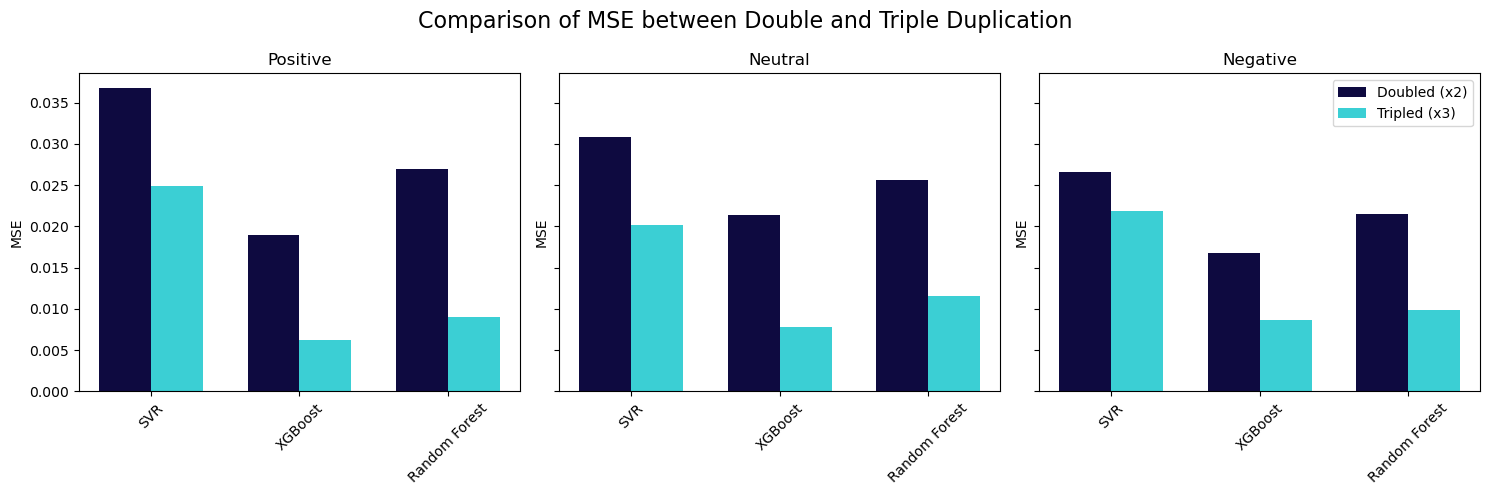

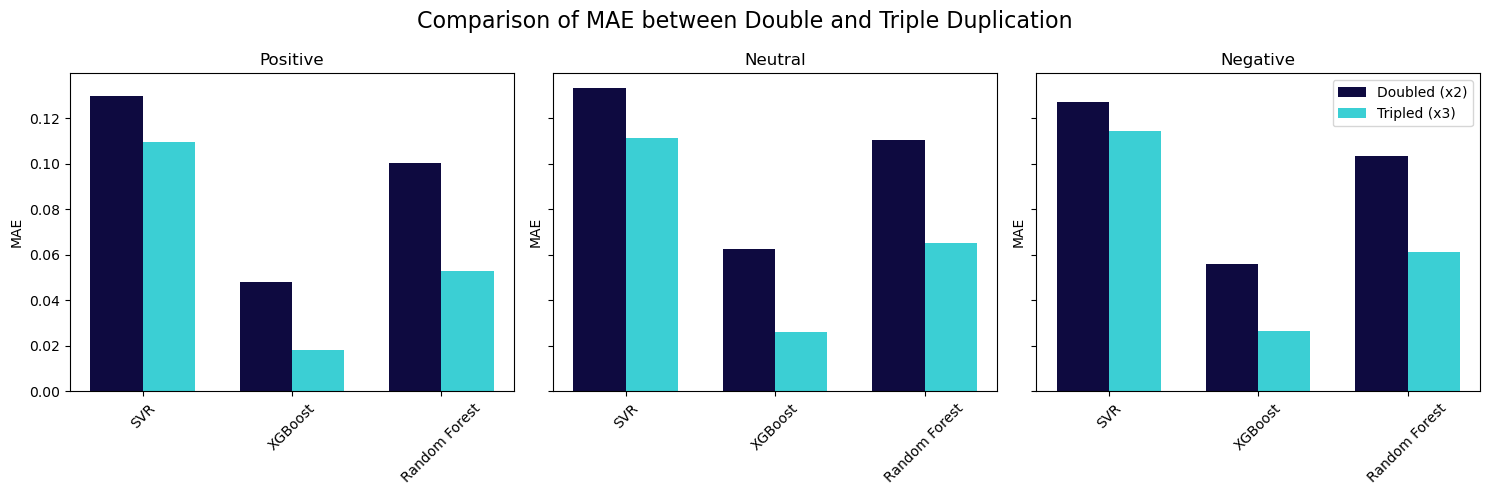

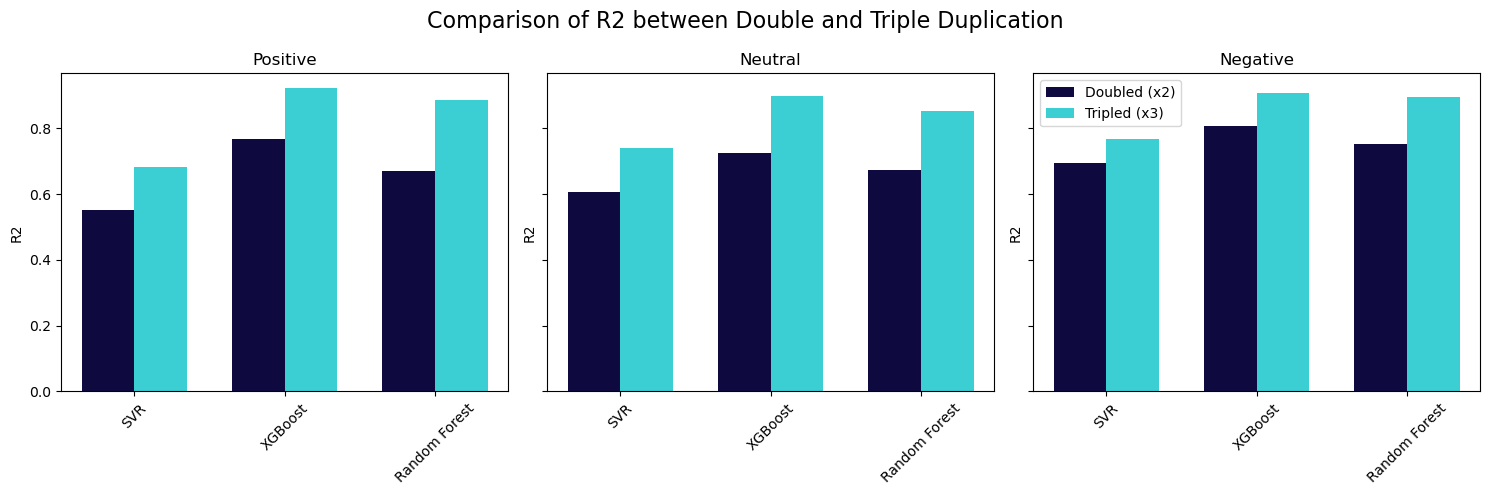

In [326]:
# Data from results
metrics_doubled = {
    'SVR': {
        'Positive': {'MSE': 0.0367, 'MAE': 0.1297, 'R2': 0.5528},
        'Neutral': {'MSE': 0.0308, 'MAE': 0.1330, 'R2': 0.6061},
        'Negative': {'MSE': 0.0266, 'MAE': 0.1270, 'R2': 0.6949}
    },
    'XGBoost': {
        'Positive': {'MSE': 0.0190, 'MAE': 0.0479, 'R2': 0.7677},
        'Neutral': {'MSE': 0.0214, 'MAE': 0.0627, 'R2': 0.7262},
        'Negative': {'MSE': 0.0168, 'MAE': 0.0561, 'R2': 0.8075}
    },
    'Random Forest': {
        'Positive': {'MSE': 0.0270, 'MAE': 0.1004, 'R2': 0.6701},
        'Neutral': {'MSE': 0.0256, 'MAE': 0.1105, 'R2': 0.6729},
        'Negative': {'MSE': 0.0215, 'MAE': 0.1034, 'R2': 0.7528}
    }
}

metrics_tripled = {
    'SVR': {
        'Positive': {'MSE': 0.0249, 'MAE': 0.1096, 'R2': 0.6831},
        'Neutral': {'MSE': 0.0201, 'MAE': 0.1111, 'R2': 0.7406},
        'Negative': {'MSE': 0.0218, 'MAE': 0.1145, 'R2': 0.7666}
    },
    'XGBoost': {
        'Positive': {'MSE': 0.0062, 'MAE': 0.0183, 'R2': 0.9213},
        'Neutral': {'MSE': 0.0078, 'MAE': 0.0260, 'R2': 0.8990},
        'Negative': {'MSE': 0.0087, 'MAE': 0.0267, 'R2': 0.9066}
    },
    'Random Forest': {
        'Positive': {'MSE': 0.0090, 'MAE': 0.0528, 'R2': 0.8852},
        'Neutral': {'MSE': 0.0115, 'MAE': 0.0650, 'R2': 0.8516},
        'Negative': {'MSE': 0.0098, 'MAE': 0.0613, 'R2': 0.8948}
    }
}

# Model names and sentiments
models = ['SVR', 'XGBoost', 'Random Forest']
sentiments = ['Positive', 'Neutral', 'Negative']
metrics = ['MSE', 'MAE', 'R2']

# Create bar charts for each metric
for metric in metrics:
    fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
    fig.suptitle(f'Comparison of {metric} between Double and Triple Duplication', fontsize=16)
    
    for i, sentiment in enumerate(sentiments):
        # Data for doubled and tripled
        doubled_values = [metrics_doubled[model][sentiment][metric] for model in models]
        tripled_values = [metrics_tripled[model][sentiment][metric] for model in models]
        
        # Bar positions
        x = np.arange(len(models))
        width = 0.35
        
        # Create bar chart
        axs[i].bar(x - width/2, doubled_values, width, label='Doubled (x2)', color='#0e0a40')
        axs[i].bar(x + width/2, tripled_values, width, label='Tripled (x3)', color='#3bcfd4')
        
        # Set axis labels and titles
        axs[i].set_title(sentiment)
        axs[i].set_xticks(x)
        axs[i].set_xticklabels(models, rotation=45)
        axs[i].set_ylabel(metric)
        
        # Add legend
        if i == 2:
            axs[i].legend()
    
    plt.tight_layout()
    plt.show()

## **Attempt 1**

In [328]:
all_reviews = [
  # รีวิว/ความคิดเห็นเกี่ยวกับธุรกิจการผลิตไฟฟ้า
    "โรงไฟฟ้าพลังงานหมุนเวียนของ กฟผ. ช่วยลดผลกระทบต่อสิ่งแวดล้อมได้ดีมากครับ ขอชื่นชม",
    "อยากให้เพิ่มจำนวนโรงไฟฟ้าพลังงานแสงอาทิตย์ให้มากขึ้น เพื่อตอบสนองความต้องการใช้พลังงานสะอาด",
    "โรงไฟฟ้าพลังความร้อนร่วม มีประสิทธิภาพในการผลิตไฟฟ้าสูงมาก แต่ก็อยากให้ควบคุมการปล่อยมลพิษให้เข้มงวดกว่านี้",
    "การรับซื้อไฟฟ้าจากผู้ผลิตเอกชนรายเล็ก ช่วยส่งเสริมผู้ประกอบการในท้องถิ่นได้ดีครับ",
    "การรับซื้อไฟฟ้าจากประเทศเพื่อนบ้าน ช่วยให้มีแหล่งพลังงานที่หลากหลายมากขึ้น",
    "ปัญหาไฟตกไฟดับยังคงเกิดขึ้นบ้างในบางพื้นที่ อยากให้ กฟผ. ปรับปรุงระบบส่งไฟฟ้าให้มีเสถียรภาพมากขึ้น",
    "อยากให้มีข้อมูลเกี่ยวกับแผนการก่อสร้างโรงไฟฟ้าแห่งใหม่ๆ ให้ประชาชนได้รับทราบมากขึ้น",
    "การมีโรงไฟฟ้าหลากหลายประเภท ช่วยให้มีแหล่งพลังงานสำรองที่มั่นคง",
    "อยากให้ กฟผ. ลงทุนในเทคโนโลยีการผลิตไฟฟ้าที่ทันสมัยมากขึ้น เพื่อลดต้นทุนและเพิ่มประสิทธิภาพ",
    "การบำรุงรักษาโรงไฟฟ้าเป็นสิ่งสำคัญ ควรมีแผนการตรวจสอบและบำรุงรักษาที่เข้มงวด",
    "โรงไฟฟ้าพลังน้ำ เป็นแหล่งพลังงานสะอาดที่สำคัญ อยากให้มีการบริหารจัดการน้ำให้มีประสิทธิภาพ",
    "การผลิตไฟฟ้าจากพลังงานลม เป็นทางเลือกที่ดีสำหรับอนาคต",
    "โรงไฟฟ้าดีเซล ควรใช้ในกรณีฉุกเฉินเท่านั้น เพื่อลดผลกระทบต่อสิ่งแวดล้อม",
    "อยากให้มีข้อมูลเกี่ยวกับการปล่อยมลพิษของโรงไฟฟ้าแต่ละแห่งให้ประชาชนเข้าถึงได้ง่าย",
    "การมีส่วนร่วมของชุมชนในการวางแผนและตัดสินใจเกี่ยวกับโรงไฟฟ้า เป็นสิ่งสำคัญ",
    "กฟผ. ควรให้ความสำคัญกับการลดผลกระทบต่อสิ่งแวดล้อมและชุมชน",
    "อยากให้มีการลงทุนในเทคโนโลยีการดักจับและกักเก็บคาร์บอนไดออกไซด์",
    "การมีแหล่งพลังงานที่หลากหลาย ช่วยลดความเสี่ยงจากการพึ่งพาแหล่งพลังงานใดแหล่งพลังงานหนึ่ง",
    "กฟผ. ควรเป็นผู้นำในการเปลี่ยนผ่านสู่พลังงานสะอาด",
    "อยากให้มีการส่งเสริมการใช้พลังงานแสงอาทิตย์บนหลังคาบ้านและอาคาร",
    "การตรวจสอบตัว VT CT ที่อยู่ในระบบ ว่าถึงช่วงกำหนดเปลี่ยนแล้วหรือไม่ หากถึงเวลาเปลี่ยนควรเปลี่ยน บางครั้งพบว่า VT ชำรุด ไม่สามารถออกหน่วยได้ใช้วิธีการเฉลี่ย",
    "อยากทราบข้อมูลเกี่ยวกับขั้นตอนการขออนุญาตติดตั้งโซลาร์ฟาร์มขนาดใหญ่",
    "มีปัญหาไฟตกบ่อยในช่วงฤดูฝน รบกวนตรวจสอบและแก้ไขด้วยครับ",
    "การยืนยันการซื้อขายไฟฟ้า ควรทำให้รวดเร็วขึ้น โดยเฉพาะในช่วงวันหยุด",
    "อยากทราบข้อมูลเกี่ยวกับแผนการพัฒนาโรงไฟฟ้าพลังงานนิวเคลียร์ของ กฟผ.",
    "การมีส่วนร่วมของชุมชนในการตัดสินใจเรื่องโรงไฟฟ้า ควรเปิดโอกาสให้มากขึ้น",
    "ร้องเรียนเรื่องเสียงดังจากโรงไฟฟ้าใกล้บ้าน รบกวนตรวจสอบด้วยครับ",
    "อยากให้มีการจัดกิจกรรมให้ความรู้เกี่ยวกับพลังงานสะอาดแก่ประชาชนมากขึ้น",
    "อยากทราบข้อมูลเกี่ยวกับโครงการสนับสนุนการติดตั้งโซลาร์รูฟท็อปสำหรับครัวเรือน",
    "ชื่นชมการทำงานของเจ้าหน้าที่ กฟผ. ที่แก้ไขปัญหาไฟดับได้อย่างรวดเร็ว",
    
    # รีวิว/ความคิดเห็นเกี่ยวกับธุรกิจการส่งไฟฟ้า
    "ระบบส่งไฟฟ้าของ กฟผ. ครอบคลุมทั่วประเทศ ทำให้มีไฟฟ้าใช้ได้อย่างทั่วถึง",
    "ปัญหาไฟตกไฟดับยังคงเกิดขึ้นบ้างในบางพื้นที่ อยากให้ปรับปรุงระบบส่งไฟฟ้าให้มีเสถียรภาพมากขึ้น",
    "อยากให้มีข้อมูลเกี่ยวกับการบำรุงรักษาระบบส่งไฟฟ้าให้ประชาชนได้รับทราบมากขึ้น",
    "การมีระบบส่งไฟฟ้าแรงดันสูง ช่วยให้ส่งไฟฟ้าได้ในปริมาณมากและระยะทางไกล",
    "อยากให้มีการลงทุนในเทคโนโลยี Smart Grid เพื่อเพิ่มประสิทธิภาพและความมั่นคงของระบบส่งไฟฟ้า",
    "การบำรุงรักษาสายส่งไฟฟ้าแรงสูง เป็นงานที่อันตรายและมีความเสี่ยงสูง ควรมีมาตรการความปลอดภัยที่เข้มงวด",
    "อยากให้มีการลดผลกระทบของสายส่งไฟฟ้าต่อสิ่งแวดล้อมและสุขภาพของประชาชน",
    "การมีส่วนร่วมของชุมชนในการวางแผนและตัดสินใจเกี่ยวกับระบบส่งไฟฟ้า เป็นสิ่งสำคัญ",
    "กฟผ. ควรให้ความสำคัญกับการลดการสูญเสียพลังงานในระบบส่งไฟฟ้า",
    "อยากให้มีการใช้สายส่งไฟฟ้าใต้ดินในพื้นที่ชุมชน เพื่อลดผลกระทบต่อทัศนียภาพ",
    "การมีระบบควบคุมและป้องกันที่ทันสมัย ช่วยลดความเสี่ยงจากไฟฟ้าดับ",
    "อยากให้มีการตรวจสอบและบำรุงรักษาสถานีไฟฟ้าแรงสูงอย่างสม่ำเสมอ",
    "การมีระบบสื่อสารและโทรคมนาคมที่ทันสมัย ช่วยให้ควบคุมและจัดการระบบส่งไฟฟ้าได้อย่างมีประสิทธิภาพ",
    "อยากให้มีการฝึกอบรมและพัฒนาบุคลากรให้มีความเชี่ยวชาญด้านระบบส่งไฟฟ้า",
    "การมีระบบสำรองฉุกเฉิน ช่วยให้มีไฟฟ้าใช้ได้อย่างต่อเนื่องในกรณีเกิดเหตุฉุกเฉิน",
    "กฟผ. ควรให้ความสำคัญกับการลดผลกระทบต่อสิ่งแวดล้อมและชุมชน",
    "อยากให้มีการลงทุนในเทคโนโลยีการป้องกันฟ้าผ่า เพื่อลดปัญหาไฟตกไฟดับ",
    "การมีแหล่งพลังงานสำรองที่มั่นคง ช่วยให้มีไฟฟ้าใช้ได้อย่างต่อเนื่องในกรณีเกิดเหตุฉุกเฉิน",
    "กฟผ. ควรเป็นผู้นำในการพัฒนาระบบส่งไฟฟ้าที่ทันสมัยและมีประสิทธิภาพ",
    "อยากให้มีการส่งเสริมการใช้เทคโนโลยี Smart Grid เพื่อเพิ่มประสิทธิภาพและความมั่นคงของระบบส่งไฟฟ้า",
    "ปัญหา Trip Reclose เนื่องจากฟ้าผ่าบ่อย ในปีที่ผ่านมา เหมือนจะมีปัญหา Trip Reclose เนื่องจากฟ้าผ่าบ่อยกว่าทุกปี ส่งผลให้เกิด Voltage Dip เป็นพื้นที่บริเวณกว้าง",
    "อยากทราบขั้นตอนการขอเชื่อมต่อระบบไฟฟ้าของโรงงานอุตสาหกรรมขนาดใหญ่",
    "สายส่งไฟฟ้าแรงสูงใกล้บ้านมีเสียงดัง รบกวนตรวจสอบและแก้ไขด้วยครับ",
    "อยากทราบข้อมูลเกี่ยวกับแผนการพัฒนาระบบสายส่งไฟฟ้าใต้ดินในพื้นที่กรุงเทพฯ",
    "การมีส่วนร่วมของชุมชนในการวางแผนระบบสายส่งไฟฟ้า ควรเปิดโอกาสให้มากขึ้น",
    "ร้องเรียนเรื่องสายส่งไฟฟ้าแรงสูงกีดขวางการก่อสร้างบ้าน รบกวนตรวจสอบด้วยครับ",
    "อยากให้มีการจัดกิจกรรมให้ความรู้เกี่ยวกับความปลอดภัยในการอยู่ใกล้สายส่งไฟฟ้าแรงสูง",
    "อยากทราบข้อมูลเกี่ยวกับโครงการปรับปรุงระบบส่งไฟฟ้าในพื้นที่ชนบท",
    "ชื่นชมการทำงานของเจ้าหน้าที่ กฟผ. ที่แก้ไขปัญหาไฟดับได้อย่างรวดเร็ว",
    "อยากให้ตรวจสอบเสาไฟฟ้าแรงสูงต้นที่อยู่หน้าบ้านของผมว่ามีรอยร้าวหรือไม่",

    # รีวิว/ความคิดเห็นเกี่ยวกับธุรกิจอื่นๆ (โรงไฟฟ้าและระบบส่ง)
    "งานวิศวกรรมและก่อสร้างโรงไฟฟ้าของ กฟผ. มีคุณภาพและได้มาตรฐาน",
    "อยากให้มีการเปิดเผยข้อมูลเกี่ยวกับงานวิศวกรรมและก่อสร้างโรงไฟฟ้าให้มากขึ้น",
    "งานเดินเครื่องและบำรุงรักษาโรงไฟฟ้าของ กฟผ. มีประสิทธิภาพและเชื่อถือได้",
    "อยากให้มีการฝึกอบรมและพัฒนาบุคลากรให้มีความเชี่ยวชาญด้านงานเดินเครื่องและบำรุงรักษาโรงไฟฟ้า",
    "งานบำรุงรักษาระบบส่งไฟฟ้าของ กฟผ. มีความสำคัญต่อความมั่นคงของระบบไฟฟ้า",
    "อยากให้มีการตรวจสอบและบำรุงรักษาสายส่งไฟฟ้าแรงสูงอย่างสม่ำเสมอ",
    "ธุรกิจโทรคมนาคมของ กฟผ. ช่วยให้มีการสื่อสารที่รวดเร็วและมีประสิทธิภาพ",
    "อยากให้มีการขยายโครงข่ายโทรคมนาคมให้ครอบคลุมพื้นที่มากขึ้น",
    "การให้บริการโครงข่ายโทรคมนาคมผ่านเส้นใยแก้วนำแสงของ กฟผ. มีความน่าสนใจ",
    "อยากให้มีการโปรโมทบริการโทรคมนาคมของ กฟผ. ให้มากขึ้น",
    "กฟผ. ควรให้ความสำคัญกับความปลอดภัยในการทำงานของบุคลากร",
    "อยากให้มีการลดผลกระทบต่อสิ่งแวดล้อมจากงานก่อสร้างและบำรุงรักษา",
    "การมีส่วนร่วมของชุมชนในการวางแผนและตัดสินใจเกี่ยวกับงานก่อสร้างและบำรุงรักษา เป็นสิ่งสำคัญ",
]